<a href="https://colab.research.google.com/github/arielba2002/Deep-Picker-Project/blob/model%2Ffinal-model%2Binference/model/DeepPicker_PreProcessing_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pre-Processing & Model Training
--------------
This notebook organizes the scraped data into a structured tensor format suitable for training and testing, and also includes the definition and training of the model itself.

# Pre-Processing

## Import Packges


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import json
import os

## Import Raw Data

### Download Raw Data

In [2]:
!gdown --id 1tD_yAa_R3eb-ssKWOu-oqxlRH0lVvQJ_ -O previous_year_data.json

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tD_yAa_R3eb-ssKWOu-oqxlRH0lVvQJ_
To: /content/previous_year_data.json
100% 8.20M/8.20M [00:00<00:00, 39.1MB/s]


### Load Raw Data

In [3]:
data_path = '/content/previous_year_data.json'

with open(data_path, 'r') as json_data:
    data = json.load(json_data)

print("Sample player data:", json.dumps(data['LAL_2020']["players"][0], indent=4))

Sample player data: {
    "id": 2517,
    "playerName": "LeBron James",
    "position": "PG",
    "age": 35,
    "games": 67,
    "gamesStarted": 67,
    "minutesPg": 2316.0,
    "fieldGoals": 643,
    "fieldAttempts": 1303,
    "fieldPercent": 0.493,
    "threeFg": 148,
    "threeAttempts": 425,
    "threePercent": 0.348,
    "twoFg": 495,
    "twoAttempts": 878,
    "twoPercent": 0.564,
    "effectFgPercent": 0.55,
    "ft": 264,
    "ftAttempts": 381,
    "ftPercent": 0.693,
    "offensiveRb": 66,
    "defensiveRb": 459,
    "totalRb": 525,
    "assists": 684,
    "steals": 78,
    "blocks": 36,
    "turnovers": 261,
    "personalFouls": 118,
    "points": 1698,
    "team": "LAL",
    "season": 2020,
    "playerId": "jamesle01"
}


## Global Constants

define global constants

In [4]:
unwanted_stats = ["id", "playerName", "team", "season", "playerId", "gamesStarted"]
per_game_stats = [
    "points", "assists", "steals", "blocks", "turnovers", "personalFouls",
    "offensiveRb", "defensiveRb", "totalRb", "fieldGoals", "fieldAttempts",
    "threeFg", "threeAttempts", "twoFg", "twoAttempts", "ft", "ftAttempts"
]
years_to_remove = [1996, 2024]
per_minute_stats = per_game_stats
team_year_filters = {"TOT": None}  # Remove all seasons of TOT


## Helper Functions (Utils)

define helper functions:

create_players_df - Converts a team-season nested dictionary into a player stats DataFrame, adding team and season columns, and extracts labels.

remove_year_data - Deletes all entries from a dataset that end with specified years.

remove_unwanted_stats - Drops unwanted statistic columns from a DataFrame.

normalize_columns - Divides specified columns by a divisor column to normalize stats (e.g., per minute).

one_hot_encode_positions - Converts player position strings into one-hot encoded columns for the 5 standard basketball positions.

prepare_team_input_and_labels - Converts the DataFrame and labels into NumPy arrays for modeling.

should_remove_team - Checks if a team-season should be excluded based on team name and optional season range filters.

pad_teams_to_max_players - Pads or truncates each team’s player data to have the same number of players for consistent input size.

In [5]:
def create_players_df(team_data, team_key):
    """
    Converts nested dictionary structure for a single team_season
    into a pandas DataFrame of player statistics and labels.
    """
    labels = team_data.get("labels", [])
    player_list = team_data.get("players", [])
    df = pd.DataFrame(player_list)

    # Extract team and season information from the team_key
    team_name, season = team_key.split("_")
    df["team"] = team_name
    df["season"] = int(season)

    return df, labels

def remove_year_data(json_data, years):
    # Build the suffix for the specific year (e.g., '1996')
    for year in years:
      year_suffix = f"_{year}"

      # Iterate over a copy of the keys to avoid modifying the dictionary while iterating
      for key in list(json_data.keys()):
          if key.endswith(year_suffix):
              del json_data[key]  # Remove the key and its value

    return json_data

def remove_unwanted_stats(df, stats_to_remove):
    """Removes unwanted statistic columns from the DataFrame."""
    return df.drop(columns=stats_to_remove, errors="ignore")

def normalize_columns(df, cols, divisor_col):
    """Normalizes specified columns by dividing them by a divisor column."""
    df = df.copy()
    for col in cols:
        if col in df.columns and divisor_col in df.columns:
            df[col] = df.apply(lambda row: row[col] / row[divisor_col] if row[divisor_col] != 0 else 0, axis=1)
    return df

def one_hot_encode_positions(df, position_col="position"):
    """
    Converts the player position column into one-hot encoded columns,
    ensuring consistent output for the 5 standard basketball positions.

    :param df: Player statistics DataFrame.
    :param position_col: Name of the column containing player positions.
    :return: DataFrame with one-hot encoded position columns.
    """
    if position_col in df.columns:
        standard_positions = ["PG", "SG", "SF", "PF", "C"]

        # Initialize zero columns
        for pos in standard_positions:
            df[f"{position_col}_{pos}"] = 0

        # Iterate through rows to set appropriate columns to 1
        for idx, value in df[position_col].dropna().items():
            # Normalize and split multi-position strings
            positions = [p.strip().upper() for p in value.replace("/", "-").split("-")]
            for pos in positions:
                col_name = f"{position_col}_{pos}"
                if col_name in df.columns:
                    df.at[idx, col_name] = 1

        # Drop the original column
        df = df.drop(columns=[position_col])

    return df


def prepare_team_input_and_labels(df, labels):
    """Prepares the final input (X) and labels (Y) for a single team."""
    X = df.to_numpy()
    Y = np.array(labels) if labels else np.array([])
    return X, Y

def should_remove_team(team_key, teams_to_remove):
    """Determines if a team should be removed based on filters."""
    if not teams_to_remove:
        return False

    team_name, season = team_key.split("_")
    season = int(season)

    if team_name in teams_to_remove:
        year_range = teams_to_remove[team_name]
        if year_range is None or (year_range[0] <= season <= year_range[1]):
            return True
    return False

def pad_teams_to_max_players(all_teams_X, max_players):
    """Pads or truncates all teams to have consistent player counts."""
    padded_teams = []
    for X_team in all_teams_X:
        if X_team.shape[0] < max_players:
            padding = np.zeros((max_players - X_team.shape[0], X_team.shape[1]))
            padded_team = np.vstack([X_team, padding])
        else:
            padded_team = X_team[:max_players]
        padded_teams.append(padded_team)
    return padded_teams


minmax_scale_last_axis - Scales each feature independently along the last axis of a multi-dimensional array to [0,1].

minmax_scale_2d - Scales each column of a 2D matrix independently to [0,1].

In [6]:
def minmax_scale_last_axis(X):
    """
    MinMax scales values along the last axis, treating each index in that axis
    independently. For each position i in the last axis, it gathers all values
    across the first two axes and scales them to the [0, 1] range.

    Parameters:
    - X: np.ndarray of shape (A, B, C), or more generally (..., C)

    Returns:
    - X_scaled: same shape as X, with values scaled per index in last axis
    """
    original_shape = X.shape
    last_dim = original_shape[-1]

    # Flatten everything but the last dimension
    reshaped = X.reshape(-1, last_dim)  # shape: (A*B*..., C)

    # Scale each column (i.e., each index in the last axis) independently
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(reshaped)

    # Reshape back to original
    X_scaled = scaled.reshape(original_shape)

    return X_scaled, scaler


def minmax_scale_2d(X):
    """
    MinMax scales each column of a 2D matrix independently to the [0, 1] range.

    Parameters:
    - X: np.ndarray of shape (n_rows, n_cols)

    Returns:
    - X_scaled: np.ndarray of same shape, scaled per column
    - scaler: fitted MinMaxScaler object
    """
    if X.ndim != 2:
        raise ValueError("Input must be a 2D numpy array")

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, scaler

## Remove Irrelevant Years

remove irrelevant years from our data

In [7]:
data = remove_year_data(data, years_to_remove)

## Single Team Preprocess Pipeline

preprocess_team_season_data - processes a single team-season’s player data by cleaning, normalizing per-minute stats, one-hot encoding positions, and returning feature and label arrays.

In [8]:
def preprocess_team_season_data(team_season_data, team_key, stats_to_remove, per_game_stats, per_minute_stats,
                                games_col="games", minutes_col="minutesPg", position_col="position"):
    """End-to-end pipeline to preprocess a single team_season entry."""
    df, labels = create_players_df(team_season_data, team_key)
    df = remove_unwanted_stats(df, stats_to_remove)
    df = normalize_columns(df, per_minute_stats, minutes_col)
    df = one_hot_encode_positions(df, position_col)
    X, Y = prepare_team_input_and_labels(df, labels)

    return X, Y


##Multiple Team Preprocess Pipeline

preprocess_multiple_teams - preprocesses multiple teams by filtering, applying single-team processing, padding players to equal lengths, and returning combined feature and label arrays.

In [9]:
def preprocess_multiple_teams(all_teams_data, stats_to_remove, per_game_stats, per_minute_stats,
                              teams_to_remove=None, games_col="games", minutes_col="minutesPg",
                              max_players_per_team=None, position_col="position"):
    """Preprocesses multiple team_season entries at once."""
    all_teams_X = []
    all_labels = []

    for team_key, team_data in all_teams_data.items():
        print(team_key)
        if should_remove_team(team_key, teams_to_remove):
            continue

        X_team, Y_team = preprocess_team_season_data(
            team_season_data=team_data,
            team_key=team_key,
            stats_to_remove=stats_to_remove,
            per_game_stats=per_game_stats,
            per_minute_stats=per_minute_stats,
            games_col=games_col,
            minutes_col=minutes_col,
            position_col=position_col
        )
        all_teams_X.append(X_team)
        all_labels.append(Y_team)

    if max_players_per_team is None:
        max_players_per_team = max(team.shape[0] for team in all_teams_X)

    padded_teams_X = pad_teams_to_max_players(all_teams_X, max_players_per_team)
    X = np.stack(padded_teams_X)
    Y = np.array(all_labels)

    return X, Y


## Small Examples (single team  & multiple teams)

In [10]:
def run_examples():
    """Run example usage for single and multiple teams."""
    team_key = "LAL_2020"
    X_lal, Y_lal = preprocess_team_season_data(
        team_season_data=data[team_key],
        team_key=team_key,
        stats_to_remove=unwanted_stats,
        per_game_stats=per_game_stats,
        per_minute_stats=per_minute_stats
    )

    print("\n*** Single Team ***")
    print("X shape:", X_lal.shape)
    print("Y shape:", Y_lal.shape)
    print("Sample X:", X_lal)

    mock_all_teams_data = {
        "LAL_2020": data["LAL_2020"],
        "PHO_1997": data["PHO_1997"],
        "PHO_1998": data["PHO_1998"],
        "LAL_2022": data["LAL_2022"]
    }

    X_all, Y_all = preprocess_multiple_teams(
        all_teams_data=mock_all_teams_data,
        stats_to_remove=unwanted_stats,
        per_game_stats=per_game_stats,
        per_minute_stats=per_minute_stats,
        teams_to_remove=team_year_filters
    )

    print("\n*** All Teams Combined ***")
    print("Combined X shape:", X_all.shape)
    print("Combined Y shape:", Y_all.shape)
    print("Sample Combined X:", X_all[0][0])
    print("Sample Combined Y:", Y_all[0])

# Uncomment to run examples
run_examples()



*** Single Team ***
X shape: (8, 30)
Y shape: (17,)
Sample X: [[3.50000000e+01 6.70000000e+01 2.31600000e+03 2.77633851e-01
  5.62607945e-01 4.93000000e-01 6.39032815e-02 1.83506045e-01
  3.48000000e-01 2.13730570e-01 3.79101900e-01 5.64000000e-01
  5.50000000e-01 1.13989637e-01 1.64507772e-01 6.93000000e-01
  2.84974093e-02 1.98186528e-01 2.26683938e-01 2.95336788e-01
  3.36787565e-02 1.55440415e-02 1.12694301e-01 5.09499136e-02
  7.33160622e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.60000000e+01 6.20000000e+01 2.13100000e+03 2.58564054e-01
  5.14312529e-01 5.03000000e-01 3.37869545e-02 1.02299390e-01
  3.30000000e-01 2.24777100e-01 4.12013139e-01 5.46000000e-01
  5.36000000e-01 2.08352886e-01 2.46363210e-01 8.46000000e-01
  6.66353824e-02 2.04129517e-01 2.70764899e-01 9.38526513e-02
  4.27029564e-02 6.71046457e-02 7.22665415e-02 7.32050680e-02
  7.59267949e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [2

## Generate Train, Validation, and Test Sets

In [11]:
X, Y = preprocess_multiple_teams(
    all_teams_data=data,
    stats_to_remove=unwanted_stats,
    per_game_stats=per_game_stats,
    per_minute_stats=per_minute_stats,
    teams_to_remove=team_year_filters,
    max_players_per_team=8  # Fixed number of players per team
)

from sklearn.model_selection import train_test_split

# Assuming X and Y are already defined, e.g., as NumPy arrays or pandas DataFrames/Series
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


# Split training data into train and validation
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_full, Y_train_full,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print(X_train_final[0])
print(Y_train_final[0])

print("====")

X_train_final, x_scaler = minmax_scale_last_axis(X_train_final)
Y_train_final, y_scaler = minmax_scale_2d(Y_train_final)

print(X_train_final[0])
print(Y_train_final[0])


print("\n*** All Teams Combined ***")
print("Combined X shape:", X.shape)
print("Combined Y shape:", Y.shape)

print("\n*** Train Teams ***")
print("X_train shape:", X_train_final.shape)
print("Y_train shape:", Y_train_final.shape)

print("\n*** Test Teams ***")
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

print("\n*** Val Teams ***")
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)



ATL_1997
BOS_1997
CHH_1997
CHI_1997
CLE_1997
DAL_1997
DEN_1997
DET_1997
GSW_1997
HOU_1997
IND_1997
LAC_1997
LAL_1997
MIA_1997
MIL_1997
MIN_1997
NJN_1997
NYK_1997
ORL_1997
PHI_1997
PHO_1997
POR_1997
SAC_1997
SAS_1997
SEA_1997
TOR_1997
TOT_1997
UTA_1997
VAN_1997
ATL_1998
BOS_1998
CHH_1998
CHI_1998
CLE_1998
DAL_1998
DEN_1998
DET_1998
GSW_1998
HOU_1998
IND_1998
LAC_1998
LAL_1998
MIA_1998
MIL_1998
MIN_1998
NJN_1998
NYK_1998
ORL_1998
PHI_1998
PHO_1998
POR_1998
SAC_1998
SAS_1998
SEA_1998
TOR_1998
TOT_1998
UTA_1998
VAN_1998
ATL_1999
BOS_1999
CHH_1999
CHI_1999
CLE_1999
DAL_1999
DEN_1999
DET_1999
GSW_1999
HOU_1999
IND_1999
LAC_1999
LAL_1999
MIA_1999
MIL_1999
MIN_1999
NJN_1999
NYK_1999
ORL_1999
PHI_1999
PHO_1999
POR_1999
SAC_1999
SAS_1999
SEA_1999
TOR_1999
TOT_1999
UTA_1999
VAN_1999
WAS_1999
ATL_2000
BOS_2000
CHH_2000
CHI_2000
CLE_2000
DAL_2000
DEN_2000
DET_2000
GSW_2000
HOU_2000
IND_2000
LAC_2000
LAL_2000
MIA_2000
MIL_2000
MIN_2000
NJN_2000
NYK_2000
ORL_2000
PHI_2000
PHO_2000
POR_2000
SAC_2000
S

## Applying Training Set Normalization

In [12]:
# Scale test data using the SAME scalers from training (no data leakage)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
Y_test_scaled = y_scaler.transform(Y_test)

print(X_test[0])
print(X_test_scaled[0])
print(Y_test[0])
print(Y_test_scaled[0])

print(f"Test X shape: {X_test_scaled.shape}")
print(f"Test Y shape: {Y_test_scaled.shape}")


[[2.90000000e+01 7.80000000e+01 2.50200000e+03 1.49880096e-01
  3.53317346e-01 4.24000000e-01 4.71622702e-02 1.33093525e-01
  3.54000000e-01 1.02717826e-01 2.20223821e-01 4.66000000e-01
  4.91000000e-01 6.67466027e-02 7.91366906e-02 8.43000000e-01
  1.07913669e-02 8.79296563e-02 9.87210232e-02 5.15587530e-02
  1.63868905e-02 2.79776179e-03 4.63629097e-02 6.67466027e-02
  4.13669065e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.60000000e+01 5.90000000e+01 1.63800000e+03 1.42857143e-01
  2.66788767e-01 5.35000000e-01 0.00000000e+00 6.10500611e-04
  0.00000000e+00 1.42857143e-01 2.66178266e-01 5.37000000e-01
  5.35000000e-01 5.98290598e-02 7.75335775e-02 7.72000000e-01
  1.15995116e-01 1.24542125e-01 2.40537241e-01 3.35775336e-02
  9.76800977e-03 5.12820513e-02 4.45665446e-02 7.44810745e-02
  3.45543346e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [2.30000000e+01 7.40000000e+01 1.46200000e+03 1.48426813e-01
  3.

In [13]:
# Scale validation data using the SAME scalers from training (no data leakage)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
Y_val_scaled = y_scaler.transform(Y_val)

print(X_val[0])
print(X_val_scaled[0])
print(Y_val[0])
print(Y_val_scaled[0])

print(f"Validation X shape: {X_val_scaled.shape}")
print(f"Validation Y shape: {Y_val_scaled.shape}")


X_val = X_val_scaled
Y_val = Y_val_scaled


[[2.40000000e+01 8.20000000e+01 3.40100000e+03 2.55219053e-01
  5.65715966e-01 4.51000000e-01 3.64598647e-02 9.52660982e-02
  3.83000000e-01 2.18759188e-01 4.70449868e-01 4.65000000e-01
  4.83000000e-01 1.76712732e-01 2.09644222e-01 8.43000000e-01
  3.11673037e-02 1.34666275e-01 1.65833578e-01 1.41428991e-01
  5.32196413e-02 1.97000882e-02 8.46809762e-02 6.40987945e-02
  7.23610703e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.40000000e+01 8.00000000e+01 3.20800000e+03 2.07294264e-01
  4.56982544e-01 4.54000000e-01 1.68329177e-02 5.67331671e-02
  2.97000000e-01 1.90461347e-01 4.00249377e-01 4.76000000e-01
  4.72000000e-01 7.79301746e-02 1.09725686e-01 7.10000000e-01
  2.46259352e-02 7.94887781e-02 1.04114713e-01 2.06670823e-01
  4.14588529e-02 6.23441397e-03 5.82917706e-02 5.64214464e-02
  5.09351621e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.90000000e+01 8.10000000e+01 2.93600000e+03 2.02656676e-01
  4.

# Model Training

###Imports

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import uuid
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import (Input, Conv1D, Dense, BatchNormalization, Dropout,
                         GlobalMaxPooling1D, GlobalAveragePooling1D, Lambda,
                         Concatenate, Add, LeakyReLU, SpatialDropout1D, Multiply,
                         TimeDistributed, LayerNormalization, GaussianNoise, MultiHeadAttention)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

## CNN Model

**Model -**

Input: 8 players × stats per team.

Multi-scale CNN: 4 branches with kernel sizes [2, 4, 6, 8] → capture patterns from small groups to full team.

Pooling: Global max + avg for each branch.

Stat branch: Mean, max, min, std, var → attention mechanism.

Fusion: CNN + stat features concatenated.

Dense layers: Deep MLP with 2 residual blocks, dropout, batch norm.

Output: Linear layer predicts 17 team performance metrics.

Optimizer: Adam with gradient clipping, LR=0.0005.

**Training -**

400 epochs, batch size 32.

EarlyStopping (patience=35), ReduceLROnPlateau, ModelCheckpoint.

**Evaluation -**

Predicts on test set.

Inverse scales predictions.

Reports MAE, RMSE, R² (overall & per metric).

Prints sample predictions.

**Visualization -**

Training loss & MAE curves.

Actual vs. predicted scatter plots per metric.

🚀 Creating enhanced CNN-based NBA model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 30)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 30)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 30)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 30)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 30)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ lambda_2[0][0],   │
│                     │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 192)    │     11,712 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 8, 192)    │     23,232 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 8, 192)    │     34,752 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 8, 192)    │     46,272 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     38,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8, 192)    │          0 │ conv1d[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 192)    │          0 │ conv1d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 192)    │          0 │ conv1d_4[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 8, 192)    │          0 │ conv1d_6[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 256)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 192)    │        768 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 192)    │        768 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 5,483,025 (20.92 MB)

 Trainable params: 5,472,017 (20.87 MB)

 Non-trainable params: 11,008 (43.00 KB)


🏀 Training improved NBA model...
Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - loss: 1.5172 - mae: 0.9816 - mse: 1.5172
Epoch 1: val_loss improved from inf to 0.23395, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1.5099 - mae: 0.9790 - mse: 1.5099 - val_loss: 0.2339 - val_mae: 0.4405 - val_mse: 0.2339 - learning_rate: 5.0000e-04
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0730 - mae: 0.8179 - mse: 1.0730
Epoch 2: val_loss improved from 0.23395 to 0.20734, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0682 - mae: 0.8161 - mse: 1.0682 - val_loss: 0.2073 - val_mae: 0.4040 - val_mse: 0.2073 - learning_rate: 5.0000e-04
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7972 - mae: 0.7032 - mse: 0.7972
Epoch 3: val_loss improved from 0.20734 to 0.17110, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7956 - mae: 0.7025 - mse: 0.7956 - val_loss: 0.1711 - val_mae: 0.3579 - val_mse: 0.1711 - learning_rate: 5.0000e-04
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6273 - mae: 0.6228 - mse: 0.6273
Epoch 4: val_loss improved from 0.17110 to 0.16529, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.6263 - mae: 0.6224 - mse: 0.6263 - val_loss: 0.1653 - val_mae: 0.3493 - val_mse: 0.1653 - learning_rate: 5.0000e-04
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5609 - mae: 0.5913 - mse: 0.5609
Epoch 5: val_loss did not improve from 0.16529
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5593 - mae: 0.5903 - mse: 0.5593 - val_loss: 0.1729 - val_mae: 0.3563 - val_mse: 0.1729 - learning_rate: 5.0000e-04
Epoch 6/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4951 - mae: 0.5555 - mse: 0.4951 
Epoch 6: val_loss improved from 0.16529 to 0.14315, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4861 - mae: 0.5491 - mse: 0.4861 - val_loss: 0.1432 - val_mae: 0.3189 - val_mse: 0.1432 - learning_rate: 5.0000e-04
Epoch 7/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4142 - mae: 0.5069 - mse: 0.4142 
Epoch 7: val_loss improved from 0.14315 to 0.13518, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4146 - mae: 0.5071 - mse: 0.4146 - val_loss: 0.1352 - val_mae: 0.3004 - val_mse: 0.1352 - learning_rate: 5.0000e-04
Epoch 8/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3810 - mae: 0.4866 - mse: 0.3810 
Epoch 8: val_loss did not improve from 0.13518
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3758 - mae: 0.4829 - mse: 0.3758 - val_loss: 0.1578 - val_mae: 0.3232 - val_mse: 0.1578 - learning_rate: 5.0000e-04
Epoch 9/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3389 - mae: 0.4614 - mse: 0.3389 
Epoch 9: val_loss did not improve from 0.13518
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3369 - mae: 0.4592 - mse: 0.3369 - val_loss: 0.1467 - val_mae: 0.3093 - val_mse: 0.1467 - learning_rate: 5.0000e-04
Epoch 10/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3070 - mae: 0.4376 - mse: 0.3070
Epoch 10: val_loss did not improve from 0.13518
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3070 - mae: 0.4375 - mse:

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2820 - mae: 0.4199 - mse: 0.2820 - val_loss: 0.1320 - val_mae: 0.2882 - val_mse: 0.1320 - learning_rate: 5.0000e-04
Epoch 12/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2670 - mae: 0.4056 - mse: 0.2670 
Epoch 12: val_loss improved from 0.13197 to 0.10281, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2601 - mae: 0.3999 - mse: 0.2601 - val_loss: 0.1028 - val_mae: 0.2474 - val_mse: 0.1028 - learning_rate: 5.0000e-04
Epoch 13/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2336 - mae: 0.3821 - mse: 0.2336 
Epoch 13: val_loss did not improve from 0.10281
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2334 - mae: 0.3820 - mse: 0.2334 - val_loss: 0.1045 - val_mae: 0.2576 - val_mse: 0.1045 - learning_rate: 5.0000e-04
Epoch 14/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2264 - mae: 0.3706 - mse: 0.2264 
Epoch 14: val_loss improved from 0.10281 to 0.09969, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2212 - mae: 0.3675 - mse: 0.2212 - val_loss: 0.0997 - val_mae: 0.2496 - val_mse: 0.0997 - learning_rate: 5.0000e-04
Epoch 15/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2009 - mae: 0.3510 - mse: 0.2009
Epoch 15: val_loss improved from 0.09969 to 0.08918, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2006 - mae: 0.3508 - mse: 0.2006 - val_loss: 0.0892 - val_mae: 0.2365 - val_mse: 0.0892 - learning_rate: 5.0000e-04
Epoch 16/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1891 - mae: 0.3442 - mse: 0.1891
Epoch 16: val_loss improved from 0.08918 to 0.08327, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1888 - mae: 0.3440 - mse: 0.1888 - val_loss: 0.0833 - val_mae: 0.2306 - val_mse: 0.0833 - learning_rate: 5.0000e-04
Epoch 17/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1640 - mae: 0.3210 - mse: 0.1640 
Epoch 17: val_loss improved from 0.08327 to 0.06920, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1638 - mae: 0.3203 - mse: 0.1638 - val_loss: 0.0692 - val_mae: 0.2096 - val_mse: 0.0692 - learning_rate: 5.0000e-04
Epoch 18/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1503 - mae: 0.3052 - mse: 0.1503 
Epoch 18: val_loss improved from 0.06920 to 0.06543, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1523 - mae: 0.3073 - mse: 0.1523 - val_loss: 0.0654 - val_mae: 0.2052 - val_mse: 0.0654 - learning_rate: 5.0000e-04
Epoch 19/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1485 - mae: 0.3002 - mse: 0.1485 
Epoch 19: val_loss did not improve from 0.06543
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1479 - mae: 0.3004 - mse: 0.1479 - val_loss: 0.0659 - val_mae: 0.2066 - val_mse: 0.0659 - learning_rate: 5.0000e-04
Epoch 20/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1399 - mae: 0.2932 - mse: 0.1399 
Epoch 20: val_loss did not improve from 0.06543
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1383 - mae: 0.2919 - mse: 0.1383 - val_loss: 0.0715 - val_mae: 0.2167 - val_mse: 0.0715 - learning_rate: 5.0000e-04
Epoch 21/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1342 - mae: 0.2860 - mse: 0.1342 
Epoch 21: val_loss did not improve from 0.06543
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1328 - mae: 0.2849 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1067 - mae: 0.2563 - mse: 0.1067 - val_loss: 0.0623 - val_mae: 0.2002 - val_mse: 0.0623 - learning_rate: 5.0000e-04
Epoch 25/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1063 - mae: 0.2546 - mse: 0.1063 
Epoch 25: val_loss improved from 0.06231 to 0.06223, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1053 - mae: 0.2537 - mse: 0.1053 - val_loss: 0.0622 - val_mae: 0.2012 - val_mse: 0.0622 - learning_rate: 5.0000e-04
Epoch 26/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1004 - mae: 0.2493 - mse: 0.1004 
Epoch 26: val_loss improved from 0.06223 to 0.05825, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1005 - mae: 0.2493 - mse: 0.1005 - val_loss: 0.0582 - val_mae: 0.1940 - val_mse: 0.0582 - learning_rate: 5.0000e-04
Epoch 27/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0943 - mae: 0.2424 - mse: 0.0943 
Epoch 27: val_loss improved from 0.05825 to 0.05733, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0949 - mae: 0.2422 - mse: 0.0949 - val_loss: 0.0573 - val_mae: 0.1911 - val_mse: 0.0573 - learning_rate: 5.0000e-04
Epoch 28/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0888 - mae: 0.2348 - mse: 0.0888
Epoch 28: val_loss improved from 0.05733 to 0.05641, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0888 - mae: 0.2348 - mse: 0.0888 - val_loss: 0.0564 - val_mae: 0.1901 - val_mse: 0.0564 - learning_rate: 5.0000e-04
Epoch 29/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0920 - mae: 0.2387 - mse: 0.0920 
Epoch 29: val_loss did not improve from 0.05641
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0899 - mae: 0.2364 - mse: 0.0899 - val_loss: 0.0588 - val_mae: 0.1936 - val_mse: 0.0588 - learning_rate: 5.0000e-04
Epoch 30/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0869 - mae: 0.2304 - mse: 0.0869 
Epoch 30: val_loss improved from 0.05641 to 0.05519, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0851 - mae: 0.2278 - mse: 0.0851 - val_loss: 0.0552 - val_mae: 0.1867 - val_mse: 0.0552 - learning_rate: 5.0000e-04
Epoch 31/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0784 - mae: 0.2189 - mse: 0.0784 
Epoch 31: val_loss improved from 0.05519 to 0.05295, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0786 - mae: 0.2190 - mse: 0.0786 - val_loss: 0.0530 - val_mae: 0.1829 - val_mse: 0.0530 - learning_rate: 5.0000e-04
Epoch 32/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0776 - mae: 0.2168 - mse: 0.0776 
Epoch 32: val_loss improved from 0.05295 to 0.05280, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0782 - mae: 0.2178 - mse: 0.0782 - val_loss: 0.0528 - val_mae: 0.1822 - val_mse: 0.0528 - learning_rate: 5.0000e-04
Epoch 33/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 - mae: 0.2129 - mse: 0.0741 
Epoch 33: val_loss did not improve from 0.05280
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0742 - mae: 0.2130 - mse: 0.0742 - val_loss: 0.0536 - val_mae: 0.1843 - val_mse: 0.0536 - learning_rate: 5.0000e-04
Epoch 34/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0749 - mae: 0.2164 - mse: 0.0749 
Epoch 34: val_loss improved from 0.05280 to 0.05151, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0747 - mae: 0.2152 - mse: 0.0747 - val_loss: 0.0515 - val_mae: 0.1799 - val_mse: 0.0515 - learning_rate: 5.0000e-04
Epoch 35/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697 - mae: 0.2079 - mse: 0.0697 
Epoch 35: val_loss improved from 0.05151 to 0.05062, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0697 - mae: 0.2071 - mse: 0.0697 - val_loss: 0.0506 - val_mae: 0.1768 - val_mse: 0.0506 - learning_rate: 5.0000e-04
Epoch 36/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0667 - mae: 0.2015 - mse: 0.0667 
Epoch 36: val_loss did not improve from 0.05062
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0683 - mae: 0.2040 - mse: 0.0683 - val_loss: 0.0531 - val_mae: 0.1806 - val_mse: 0.0531 - learning_rate: 5.0000e-04
Epoch 37/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0626 - mae: 0.1957 - mse: 0.0626 
Epoch 37: val_loss did not improve from 0.05062
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0643 - mae: 0.1980 - mse: 0.0643 - val_loss: 0.0527 - val_mae: 0.1797 - val_mse: 0.0527 - learning_rate: 5.0000e-04
Epoch 38/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0613 - mae: 0.1944 - mse: 0.0613 
Epoch 38: val_loss did not improve from 0.05062
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0615 - mae: 0.1945 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0586 - mae: 0.1890 - mse: 0.0586 - val_loss: 0.0485 - val_mae: 0.1720 - val_mse: 0.0485 - learning_rate: 5.0000e-04
Epoch 42/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0615 - mae: 0.1937 - mse: 0.0615 
Epoch 42: val_loss improved from 0.04848 to 0.04763, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0598 - mae: 0.1912 - mse: 0.0598 - val_loss: 0.0476 - val_mae: 0.1709 - val_mse: 0.0476 - learning_rate: 5.0000e-04
Epoch 43/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0551 - mae: 0.1836 - mse: 0.0551
Epoch 43: val_loss did not improve from 0.04763
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0551 - mae: 0.1837 - mse: 0.0551 - val_loss: 0.0498 - val_mae: 0.1738 - val_mse: 0.0498 - learning_rate: 5.0000e-04
Epoch 44/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0548 - mae: 0.1828 - mse: 0.0548 
Epoch 44: val_loss did not improve from 0.04763
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0546 - mae: 0.1821 - mse: 0.0546 - val_loss: 0.0494 - val_mae: 0.1740 - val_mse: 0.0494 - learning_rate: 5.0000e-04
Epoch 45/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0528 - mae: 0.1791 - mse: 0.0528
Epoch 45: val_loss improved from 0.04763 to 0.04595, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0528 - mae: 0.1791 - mse: 0.0528 - val_loss: 0.0459 - val_mae: 0.1679 - val_mse: 0.0459 - learning_rate: 5.0000e-04
Epoch 46/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0501 - mae: 0.1748 - mse: 0.0501 
Epoch 46: val_loss did not improve from 0.04595
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0513 - mae: 0.1766 - mse: 0.0513 - val_loss: 0.0480 - val_mae: 0.1714 - val_mse: 0.0480 - learning_rate: 5.0000e-04
Epoch 47/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0504 - mae: 0.1743 - mse: 0.0504 
Epoch 47: val_loss improved from 0.04595 to 0.04545, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0510 - mae: 0.1753 - mse: 0.0510 - val_loss: 0.0455 - val_mae: 0.1665 - val_mse: 0.0455 - learning_rate: 5.0000e-04
Epoch 48/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0509 - mae: 0.1753 - mse: 0.0509 
Epoch 48: val_loss improved from 0.04545 to 0.04510, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0508 - mae: 0.1754 - mse: 0.0508 - val_loss: 0.0451 - val_mae: 0.1651 - val_mse: 0.0451 - learning_rate: 5.0000e-04
Epoch 49/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - mae: 0.1729 - mse: 0.0482 
Epoch 49: val_loss improved from 0.04510 to 0.04306, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0482 - mae: 0.1729 - mse: 0.0482 - val_loss: 0.0431 - val_mae: 0.1619 - val_mse: 0.0431 - learning_rate: 5.0000e-04
Epoch 50/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0537 - mae: 0.1804 - mse: 0.0537 
Epoch 50: val_loss improved from 0.04306 to 0.04246, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0520 - mae: 0.1773 - mse: 0.0520 - val_loss: 0.0425 - val_mae: 0.1613 - val_mse: 0.0425 - learning_rate: 5.0000e-04
Epoch 51/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0487 - mae: 0.1723 - mse: 0.0487
Epoch 51: val_loss did not improve from 0.04246
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0487 - mae: 0.1723 - mse: 0.0487 - val_loss: 0.0425 - val_mae: 0.1608 - val_mse: 0.0425 - learning_rate: 5.0000e-04
Epoch 52/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0467 - mae: 0.1685 - mse: 0.0467 
Epoch 52: val_loss improved from 0.04246 to 0.04141, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0469 - mae: 0.1682 - mse: 0.0469 - val_loss: 0.0414 - val_mae: 0.1580 - val_mse: 0.0414 - learning_rate: 5.0000e-04
Epoch 53/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0471 - mae: 0.1673 - mse: 0.0471 
Epoch 53: val_loss improved from 0.04141 to 0.04052, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0468 - mae: 0.1672 - mse: 0.0468 - val_loss: 0.0405 - val_mae: 0.1563 - val_mse: 0.0405 - learning_rate: 5.0000e-04
Epoch 54/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0457 - mae: 0.1667 - mse: 0.0457
Epoch 54: val_loss improved from 0.04052 to 0.03966, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0457 - mae: 0.1667 - mse: 0.0457 - val_loss: 0.0397 - val_mae: 0.1545 - val_mse: 0.0397 - learning_rate: 5.0000e-04
Epoch 55/400
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0448 - mae: 0.1646 - mse: 0.0448
Epoch 55: val_loss improved from 0.03966 to 0.03819, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0446 - mae: 0.1643 - mse: 0.0446 - val_loss: 0.0382 - val_mae: 0.1519 - val_mse: 0.0382 - learning_rate: 5.0000e-04
Epoch 56/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0467 - mae: 0.1683 - mse: 0.0467 
Epoch 56: val_loss improved from 0.03819 to 0.03687, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0457 - mae: 0.1659 - mse: 0.0457 - val_loss: 0.0369 - val_mae: 0.1489 - val_mse: 0.0369 - learning_rate: 5.0000e-04
Epoch 57/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mae: 0.1619 - mse: 0.0432 
Epoch 57: val_loss improved from 0.03687 to 0.03660, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0433 - mae: 0.1621 - mse: 0.0433 - val_loss: 0.0366 - val_mae: 0.1492 - val_mse: 0.0366 - learning_rate: 5.0000e-04
Epoch 58/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0421 - mae: 0.1591 - mse: 0.0421
Epoch 58: val_loss did not improve from 0.03660
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0421 - mae: 0.1592 - mse: 0.0421 - val_loss: 0.0366 - val_mae: 0.1493 - val_mse: 0.0366 - learning_rate: 5.0000e-04
Epoch 59/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0410 - mae: 0.1583 - mse: 0.0410
Epoch 59: val_loss improved from 0.03660 to 0.03548, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0410 - mae: 0.1584 - mse: 0.0410 - val_loss: 0.0355 - val_mae: 0.1467 - val_mse: 0.0355 - learning_rate: 5.0000e-04
Epoch 60/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 - mae: 0.1620 - mse: 0.0438 
Epoch 60: val_loss did not improve from 0.03548
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431 - mae: 0.1608 - mse: 0.0431 - val_loss: 0.0357 - val_mae: 0.1466 - val_mse: 0.0357 - learning_rate: 5.0000e-04
Epoch 61/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0408 - mae: 0.1572 - mse: 0.0408 
Epoch 61: val_loss improved from 0.03548 to 0.03386, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0406 - mae: 0.1569 - mse: 0.0406 - val_loss: 0.0339 - val_mae: 0.1429 - val_mse: 0.0339 - learning_rate: 5.0000e-04
Epoch 62/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395 - mae: 0.1540 - mse: 0.0395 
Epoch 62: val_loss did not improve from 0.03386
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0399 - mae: 0.1548 - mse: 0.0399 - val_loss: 0.0344 - val_mae: 0.1442 - val_mse: 0.0344 - learning_rate: 5.0000e-04
Epoch 63/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0419 - mae: 0.1600 - mse: 0.0419 
Epoch 63: val_loss improved from 0.03386 to 0.03356, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0412 - mae: 0.1582 - mse: 0.0412 - val_loss: 0.0336 - val_mae: 0.1421 - val_mse: 0.0336 - learning_rate: 5.0000e-04
Epoch 64/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - mae: 0.1519 - mse: 0.0380
Epoch 64: val_loss improved from 0.03356 to 0.03297, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0380 - mae: 0.1519 - mse: 0.0380 - val_loss: 0.0330 - val_mae: 0.1401 - val_mse: 0.0330 - learning_rate: 5.0000e-04
Epoch 65/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 - mae: 0.1540 - mse: 0.0396
Epoch 65: val_loss did not improve from 0.03297
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0396 - mae: 0.1539 - mse: 0.0396 - val_loss: 0.0334 - val_mae: 0.1411 - val_mse: 0.0334 - learning_rate: 5.0000e-04
Epoch 66/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0422 - mae: 0.1578 - mse: 0.0422
Epoch 66: val_loss did not improve from 0.03297
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0420 - mae: 0.1575 - mse: 0.0420 - val_loss: 0.0334 - val_mae: 0.1415 - val_mse: 0.0334 - learning_rate: 5.0000e-04
Epoch 67/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0358 - mae: 0.1491 - mse: 0.0358 
Epoch 67: val_loss improved from 0.03297 to 0.03128, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0368 - mae: 0.1507 - mse: 0.0368 - val_loss: 0.0313 - val_mae: 0.1355 - val_mse: 0.0313 - learning_rate: 5.0000e-04
Epoch 68/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0402 - mae: 0.1546 - mse: 0.0402 
Epoch 68: val_loss did not improve from 0.03128
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0395 - mae: 0.1537 - mse: 0.0395 - val_loss: 0.0323 - val_mae: 0.1379 - val_mse: 0.0323 - learning_rate: 5.0000e-04
Epoch 69/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368 - mae: 0.1487 - mse: 0.0368 
Epoch 69: val_loss did not improve from 0.03128
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0365 - mae: 0.1479 - mse: 0.0365 - val_loss: 0.0325 - val_mae: 0.1386 - val_mse: 0.0325 - learning_rate: 5.0000e-04
Epoch 70/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0372 - mae: 0.1503 - mse: 0.0372 
Epoch 70: val_loss did not improve from 0.03128
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0372 - mae: 0.1503 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0378 - mae: 0.1491 - mse: 0.0378 - val_loss: 0.0311 - val_mae: 0.1352 - val_mse: 0.0311 - learning_rate: 5.0000e-04
Epoch 72/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0374 - mae: 0.1497 - mse: 0.0374 
Epoch 72: val_loss did not improve from 0.03111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0366 - mae: 0.1479 - mse: 0.0366 - val_loss: 0.0320 - val_mae: 0.1377 - val_mse: 0.0320 - learning_rate: 5.0000e-04
Epoch 73/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0378 - mae: 0.1505 - mse: 0.0378 
Epoch 73: val_loss did not improve from 0.03111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0370 - mae: 0.1490 - mse: 0.0370 - val_loss: 0.0320 - val_mae: 0.1374 - val_mse: 0.0320 - learning_rate: 5.0000e-04
Epoch 74/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0357 - mae: 0.1451 - mse: 0.0357 
Epoch 74: val_loss improved from 0.03111 to 0.03076, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0359 - mae: 0.1460 - mse: 0.0359 - val_loss: 0.0308 - val_mae: 0.1348 - val_mse: 0.0308 - learning_rate: 5.0000e-04
Epoch 75/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368 - mae: 0.1483 - mse: 0.0368 
Epoch 75: val_loss did not improve from 0.03076
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0358 - mae: 0.1465 - mse: 0.0358 - val_loss: 0.0311 - val_mae: 0.1356 - val_mse: 0.0311 - learning_rate: 5.0000e-04
Epoch 76/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342 - mae: 0.1442 - mse: 0.0342 
Epoch 76: val_loss did not improve from 0.03076
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0342 - mae: 0.1438 - mse: 0.0342 - val_loss: 0.0309 - val_mae: 0.1352 - val_mse: 0.0309 - learning_rate: 5.0000e-04
Epoch 77/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0351 - mae: 0.1450 - mse: 0.0351 
Epoch 77: val_loss did not improve from 0.03076
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0351 - mae: 0.1452 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0329 - mae: 0.1409 - mse: 0.0329 - val_loss: 0.0298 - val_mae: 0.1321 - val_mse: 0.0298 - learning_rate: 5.0000e-04
Epoch 79/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0331 - mae: 0.1413 - mse: 0.0331
Epoch 79: val_loss did not improve from 0.02978
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0330 - mae: 0.1413 - mse: 0.0330 - val_loss: 0.0301 - val_mae: 0.1333 - val_mse: 0.0301 - learning_rate: 5.0000e-04
Epoch 80/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347 - mae: 0.1446 - mse: 0.0347 
Epoch 80: val_loss did not improve from 0.02978
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0344 - mae: 0.1438 - mse: 0.0344 - val_loss: 0.0299 - val_mae: 0.1321 - val_mse: 0.0299 - learning_rate: 5.0000e-04
Epoch 81/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342 - mae: 0.1421 - mse: 0.0342
Epoch 81: val_loss did not improve from 0.02978
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0341 - mae: 0.1420 - m

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0317 - mae: 0.1373 - mse: 0.0317 - val_loss: 0.0293 - val_mae: 0.1314 - val_mse: 0.0293 - learning_rate: 5.0000e-04
Epoch 84/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0328 - mae: 0.1405 - mse: 0.0328
Epoch 84: val_loss did not improve from 0.02934
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0328 - mae: 0.1405 - mse: 0.0328 - val_loss: 0.0298 - val_mae: 0.1328 - val_mse: 0.0298 - learning_rate: 5.0000e-04
Epoch 85/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0320 - mae: 0.1377 - mse: 0.0320 
Epoch 85: val_loss did not improve from 0.02934
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0318 - mae: 0.1376 - mse: 0.0318 - val_loss: 0.0298 - val_mae: 0.1332 - val_mse: 0.0298 - learning_rate: 5.0000e-04
Epoch 86/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0317 - mae: 0.1372 - mse: 0.0317 
Epoch 86: val_loss did not improve from 0.02934
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0319 - mae: 0.1381 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0325 - mae: 0.1378 - mse: 0.0325 - val_loss: 0.0285 - val_mae: 0.1302 - val_mse: 0.0285 - learning_rate: 5.0000e-04
Epoch 88/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0322 - mae: 0.1395 - mse: 0.0322
Epoch 88: val_loss did not improve from 0.02848
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0322 - mae: 0.1395 - mse: 0.0322 - val_loss: 0.0291 - val_mae: 0.1319 - val_mse: 0.0291 - learning_rate: 5.0000e-04
Epoch 89/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0319 - mae: 0.1386 - mse: 0.0319
Epoch 89: val_loss improved from 0.02848 to 0.02792, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0318 - mae: 0.1385 - mse: 0.0318 - val_loss: 0.0279 - val_mae: 0.1281 - val_mse: 0.0279 - learning_rate: 5.0000e-04
Epoch 90/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0313 - mae: 0.1373 - mse: 0.0313 
Epoch 90: val_loss did not improve from 0.02792
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0312 - mae: 0.1365 - mse: 0.0312 - val_loss: 0.0283 - val_mae: 0.1292 - val_mse: 0.0283 - learning_rate: 5.0000e-04
Epoch 91/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0305 - mae: 0.1349 - mse: 0.0305 
Epoch 91: val_loss did not improve from 0.02792
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - mae: 0.1356 - mse: 0.0306 - val_loss: 0.0285 - val_mae: 0.1293 - val_mse: 0.0285 - learning_rate: 5.0000e-04
Epoch 92/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - mae: 0.1333 - mse: 0.0291 
Epoch 92: val_loss did not improve from 0.02792
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - mae: 0.1348 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0288 - mae: 0.1332 - mse: 0.0288 - val_loss: 0.0268 - val_mae: 0.1253 - val_mse: 0.0268 - learning_rate: 5.0000e-04
Epoch 97/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0294 - mae: 0.1334 - mse: 0.0294
Epoch 97: val_loss improved from 0.02677 to 0.02670, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0294 - mae: 0.1334 - mse: 0.0294 - val_loss: 0.0267 - val_mae: 0.1257 - val_mse: 0.0267 - learning_rate: 5.0000e-04
Epoch 98/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297 - mae: 0.1340 - mse: 0.0297
Epoch 98: val_loss did not improve from 0.02670
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0296 - mae: 0.1339 - mse: 0.0296 - val_loss: 0.0271 - val_mae: 0.1261 - val_mse: 0.0271 - learning_rate: 5.0000e-04
Epoch 99/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - mae: 0.1339 - mse: 0.0295 
Epoch 99: val_loss improved from 0.02670 to 0.02663, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0293 - mae: 0.1332 - mse: 0.0293 - val_loss: 0.0266 - val_mae: 0.1252 - val_mse: 0.0266 - learning_rate: 5.0000e-04
Epoch 100/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0278 - mae: 0.1291 - mse: 0.0278
Epoch 100: val_loss did not improve from 0.02663
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0278 - mae: 0.1291 - mse: 0.0278 - val_loss: 0.0275 - val_mae: 0.1273 - val_mse: 0.0275 - learning_rate: 5.0000e-04
Epoch 101/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0294 - mae: 0.1335 - mse: 0.0294 
Epoch 101: val_loss improved from 0.02663 to 0.02653, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0293 - mae: 0.1329 - mse: 0.0293 - val_loss: 0.0265 - val_mae: 0.1257 - val_mse: 0.0265 - learning_rate: 5.0000e-04
Epoch 102/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - mae: 0.1300 - mse: 0.0283 
Epoch 102: val_loss improved from 0.02653 to 0.02576, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0283 - mae: 0.1300 - mse: 0.0283 - val_loss: 0.0258 - val_mae: 0.1231 - val_mse: 0.0258 - learning_rate: 5.0000e-04
Epoch 103/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0292 - mae: 0.1308 - mse: 0.0292 
Epoch 103: val_loss did not improve from 0.02576
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0288 - mae: 0.1304 - mse: 0.0288 - val_loss: 0.0264 - val_mae: 0.1238 - val_mse: 0.0264 - learning_rate: 5.0000e-04
Epoch 104/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273 - mae: 0.1291 - mse: 0.0273 
Epoch 104: val_loss did not improve from 0.02576
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273 - mae: 0.1287 - mse: 0.0273 - val_loss: 0.0262 - val_mae: 0.1233 - val_mse: 0.0262 - learning_rate: 5.0000e-04
Epoch 105/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0278 - mae: 0.1287 - mse: 0.0278 
Epoch 105: val_loss did not improve from 0.02576
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0276 - mae: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0278 - mae: 0.1293 - mse: 0.0278 - val_loss: 0.0255 - val_mae: 0.1220 - val_mse: 0.0255 - learning_rate: 5.0000e-04
Epoch 107/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0272 - mae: 0.1273 - mse: 0.0272
Epoch 107: val_loss did not improve from 0.02552
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0273 - mae: 0.1274 - mse: 0.0273 - val_loss: 0.0262 - val_mae: 0.1239 - val_mse: 0.0262 - learning_rate: 5.0000e-04
Epoch 108/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 - mae: 0.1244 - mse: 0.0252 
Epoch 108: val_loss did not improve from 0.02552
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0263 - mae: 0.1266 - mse: 0.0263 - val_loss: 0.0257 - val_mae: 0.1226 - val_mse: 0.0257 - learning_rate: 5.0000e-04
Epoch 109/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 - mae: 0.1280 - mse: 0.0275 
Epoch 109: val_loss did not improve from 0.02552
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0276 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0259 - mae: 0.1250 - mse: 0.0259 - val_loss: 0.0249 - val_mae: 0.1208 - val_mse: 0.0249 - learning_rate: 5.0000e-04
Epoch 115/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0260 - mae: 0.1238 - mse: 0.0260
Epoch 115: val_loss did not improve from 0.02486
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0260 - mae: 0.1238 - mse: 0.0260 - val_loss: 0.0256 - val_mae: 0.1231 - val_mse: 0.0256 - learning_rate: 5.0000e-04
Epoch 116/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 - mae: 0.1272 - mse: 0.0275
Epoch 116: val_loss improved from 0.02486 to 0.02481, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0274 - mae: 0.1271 - mse: 0.0274 - val_loss: 0.0248 - val_mae: 0.1213 - val_mse: 0.0248 - learning_rate: 5.0000e-04
Epoch 117/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0269 - mae: 0.1279 - mse: 0.0269 
Epoch 117: val_loss improved from 0.02481 to 0.02459, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0266 - mae: 0.1269 - mse: 0.0266 - val_loss: 0.0246 - val_mae: 0.1202 - val_mse: 0.0246 - learning_rate: 5.0000e-04
Epoch 118/400
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - mae: 0.1226 - mse: 0.0249
Epoch 118: val_loss improved from 0.02459 to 0.02393, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0249 - mae: 0.1226 - mse: 0.0249 - val_loss: 0.0239 - val_mae: 0.1185 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 119/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mae: 0.1270 - mse: 0.0266
Epoch 119: val_loss did not improve from 0.02393
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0266 - mae: 0.1269 - mse: 0.0266 - val_loss: 0.0245 - val_mae: 0.1201 - val_mse: 0.0245 - learning_rate: 5.0000e-04
Epoch 120/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mae: 0.1233 - mse: 0.0256 
Epoch 120: val_loss did not improve from 0.02393
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - mae: 0.1236 - mse: 0.0257 - val_loss: 0.0252 - val_mae: 0.1218 - val_mse: 0.0252 - learning_rate: 5.0000e-04
Epoch 121/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - mae: 0.1240 - mse: 0.0257
Epoch 121: val_loss did not improve from 0.02393
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0256 - mae: 0.12

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0242 - mae: 0.1203 - mse: 0.0242 - val_loss: 0.0238 - val_mae: 0.1180 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 128/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0247 - mae: 0.1203 - mse: 0.0247 
Epoch 128: val_loss did not improve from 0.02382
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247 - mae: 0.1203 - mse: 0.0247 - val_loss: 0.0242 - val_mae: 0.1192 - val_mse: 0.0242 - learning_rate: 5.0000e-04
Epoch 129/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0233 - mae: 0.1181 - mse: 0.0233 
Epoch 129: val_loss improved from 0.02382 to 0.02363, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - mae: 0.1187 - mse: 0.0234 - val_loss: 0.0236 - val_mae: 0.1175 - val_mse: 0.0236 - learning_rate: 5.0000e-04
Epoch 130/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - mae: 0.1195 - mse: 0.0235 
Epoch 130: val_loss did not improve from 0.02363
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - mae: 0.1194 - mse: 0.0236 - val_loss: 0.0238 - val_mae: 0.1180 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 131/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - mae: 0.1144 - mse: 0.0219 
Epoch 131: val_loss did not improve from 0.02363
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228 - mae: 0.1168 - mse: 0.0228 - val_loss: 0.0240 - val_mae: 0.1184 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 132/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - mae: 0.1171 - mse: 0.0229
Epoch 132: val_loss did not improve from 0.02363
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0229 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0230 - mae: 0.1174 - mse: 0.0230 - val_loss: 0.0230 - val_mae: 0.1163 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 136/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 - mae: 0.1146 - mse: 0.0220 
Epoch 136: val_loss did not improve from 0.02303
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223 - mae: 0.1154 - mse: 0.0223 - val_loss: 0.0237 - val_mae: 0.1182 - val_mse: 0.0237 - learning_rate: 5.0000e-04
Epoch 137/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232 - mae: 0.1173 - mse: 0.0232 
Epoch 137: val_loss did not improve from 0.02303
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0230 - mae: 0.1168 - mse: 0.0230 - val_loss: 0.0232 - val_mae: 0.1170 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 138/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - mae: 0.1181 - mse: 0.0234 
Epoch 138: val_loss did not improve from 0.02303
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - mae: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0222 - mae: 0.1158 - mse: 0.0222 - val_loss: 0.0230 - val_mae: 0.1161 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 141/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0223 - mae: 0.1154 - mse: 0.0223
Epoch 141: val_loss did not improve from 0.02300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - mae: 0.1154 - mse: 0.0223 - val_loss: 0.0232 - val_mae: 0.1166 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 142/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - mae: 0.1180 - mse: 0.0229 
Epoch 142: val_loss did not improve from 0.02300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228 - mae: 0.1175 - mse: 0.0228 - val_loss: 0.0231 - val_mae: 0.1168 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 143/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - mae: 0.1149 - mse: 0.0219 
Epoch 143: val_loss did not improve from 0.02300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0217 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0230 - mae: 0.1179 - mse: 0.0230 - val_loss: 0.0227 - val_mae: 0.1147 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 145/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0216 - mae: 0.1144 - mse: 0.0216 
Epoch 145: val_loss improved from 0.02272 to 0.02230, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0219 - mae: 0.1156 - mse: 0.0219 - val_loss: 0.0223 - val_mae: 0.1139 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 146/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - mae: 0.1166 - mse: 0.0229
Epoch 146: val_loss did not improve from 0.02230
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0229 - mae: 0.1166 - mse: 0.0229 - val_loss: 0.0233 - val_mae: 0.1170 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 147/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - mae: 0.1123 - mse: 0.0208
Epoch 147: val_loss did not improve from 0.02230
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0208 - mae: 0.1124 - mse: 0.0208 - val_loss: 0.0237 - val_mae: 0.1179 - val_mse: 0.0237 - learning_rate: 5.0000e-04
Epoch 148/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - mae: 0.1133 - mse: 0.0214
Epoch 148: val_loss did not improve from 0.02230
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mae: 0.113

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0197 - mae: 0.1085 - mse: 0.0197 - val_loss: 0.0222 - val_mae: 0.1138 - val_mse: 0.0222 - learning_rate: 1.0000e-04
Epoch 165/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - mae: 0.1115 - mse: 0.0206
Epoch 165: val_loss did not improve from 0.02219
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0206 - mae: 0.1115 - mse: 0.0206 - val_loss: 0.0222 - val_mae: 0.1140 - val_mse: 0.0222 - learning_rate: 1.0000e-04
Epoch 166/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - mae: 0.1124 - mse: 0.0210
Epoch 166: val_loss did not improve from 0.02219
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0210 - mae: 0.1123 - mse: 0.0210 - val_loss: 0.0223 - val_mae: 0.1141 - val_mse: 0.0223 - learning_rate: 1.0000e-04
Epoch 167/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - mae: 0.1133 - mse: 0.0210
Epoch 167: val_loss did not improve from 0.02219
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0210 - mae: 0.113

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0198 - mae: 0.1096 - mse: 0.0198 - val_loss: 0.0222 - val_mae: 0.1135 - val_mse: 0.0222 - learning_rate: 2.0000e-05
Epoch 193/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - mae: 0.1099 - mse: 0.0201 
Epoch 193: val_loss improved from 0.02218 to 0.02218, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0201 - mae: 0.1104 - mse: 0.0201 - val_loss: 0.0222 - val_mae: 0.1135 - val_mse: 0.0222 - learning_rate: 2.0000e-05
Epoch 194/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - mae: 0.1088 - mse: 0.0190 
Epoch 194: val_loss improved from 0.02218 to 0.02214, saving model to cnn_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0191 - mae: 0.1085 - mse: 0.0191 - val_loss: 0.0221 - val_mae: 0.1134 - val_mse: 0.0221 - learning_rate: 2.0000e-05
Epoch 195/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0184 - mae: 0.1052 - mse: 0.0184 
Epoch 195: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.

Epoch 195: val_loss did not improve from 0.02214
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - mae: 0.1063 - mse: 0.0188 - val_loss: 0.0222 - val_mae: 0.1134 - val_mse: 0.0222 - learning_rate: 2.0000e-05
Epoch 196/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - mae: 0.1103 - mse: 0.0196 
Epoch 196: val_loss did not improve from 0.02214
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197 - mae: 0.1099 - mse: 0.0197 - val_loss: 0.0222 - val_mae: 0.1133 - val_mse: 0.0222 - learning_rate: 4.0000e-06
Epoch 197/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0200 - mae: 0.1102 - mse: 0.0200 
Epoch 197: val_loss did not improv

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0191 - mae: 0.1070 - mse: 0.0191 - val_loss: 0.0221 - val_mae: 0.1133 - val_mse: 0.0221 - learning_rate: 4.0000e-06
Epoch 200/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207 - mae: 0.1121 - mse: 0.0207
Epoch 200: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - mae: 0.1120 - mse: 0.0207 - val_loss: 0.0222 - val_mae: 0.1133 - val_mse: 0.0222 - learning_rate: 4.0000e-06
Epoch 201/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - mae: 0.1074 - mse: 0.0189
Epoch 201: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - mae: 0.1075 - mse: 0.0189 - val_loss: 0.0222 - val_mae: 0.1134 - val_mse: 0.0222 - learning_rate: 4.0000e-06
Epoch 202/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193 - mae: 0.1078 - mse: 0.0193 
Epoch 202: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - mae: 0.10

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0191 - mae: 0.1082 - mse: 0.0191 - val_loss: 0.0221 - val_mae: 0.1132 - val_mse: 0.0221 - learning_rate: 8.0000e-07
Epoch 216/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mae: 0.1097 - mse: 0.0199
Epoch 216: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - mae: 0.1098 - mse: 0.0200 - val_loss: 0.0221 - val_mae: 0.1132 - val_mse: 0.0221 - learning_rate: 8.0000e-07
Epoch 217/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - mae: 0.1107 - mse: 0.0205 
Epoch 217: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0200 - mae: 0.1094 - mse: 0.0200 - val_loss: 0.0222 - val_mae: 0.1134 - val_mse: 0.0222 - learning_rate: 8.0000e-07
Epoch 218/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mae: 0.1098 - mse: 0.0199 
Epoch 218: val_loss did not improve from 0.02213
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197 - mae: 0.1

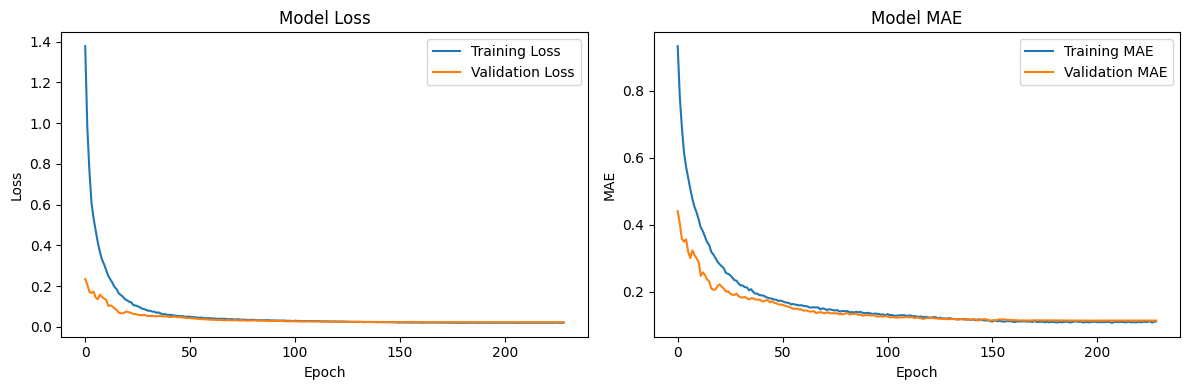

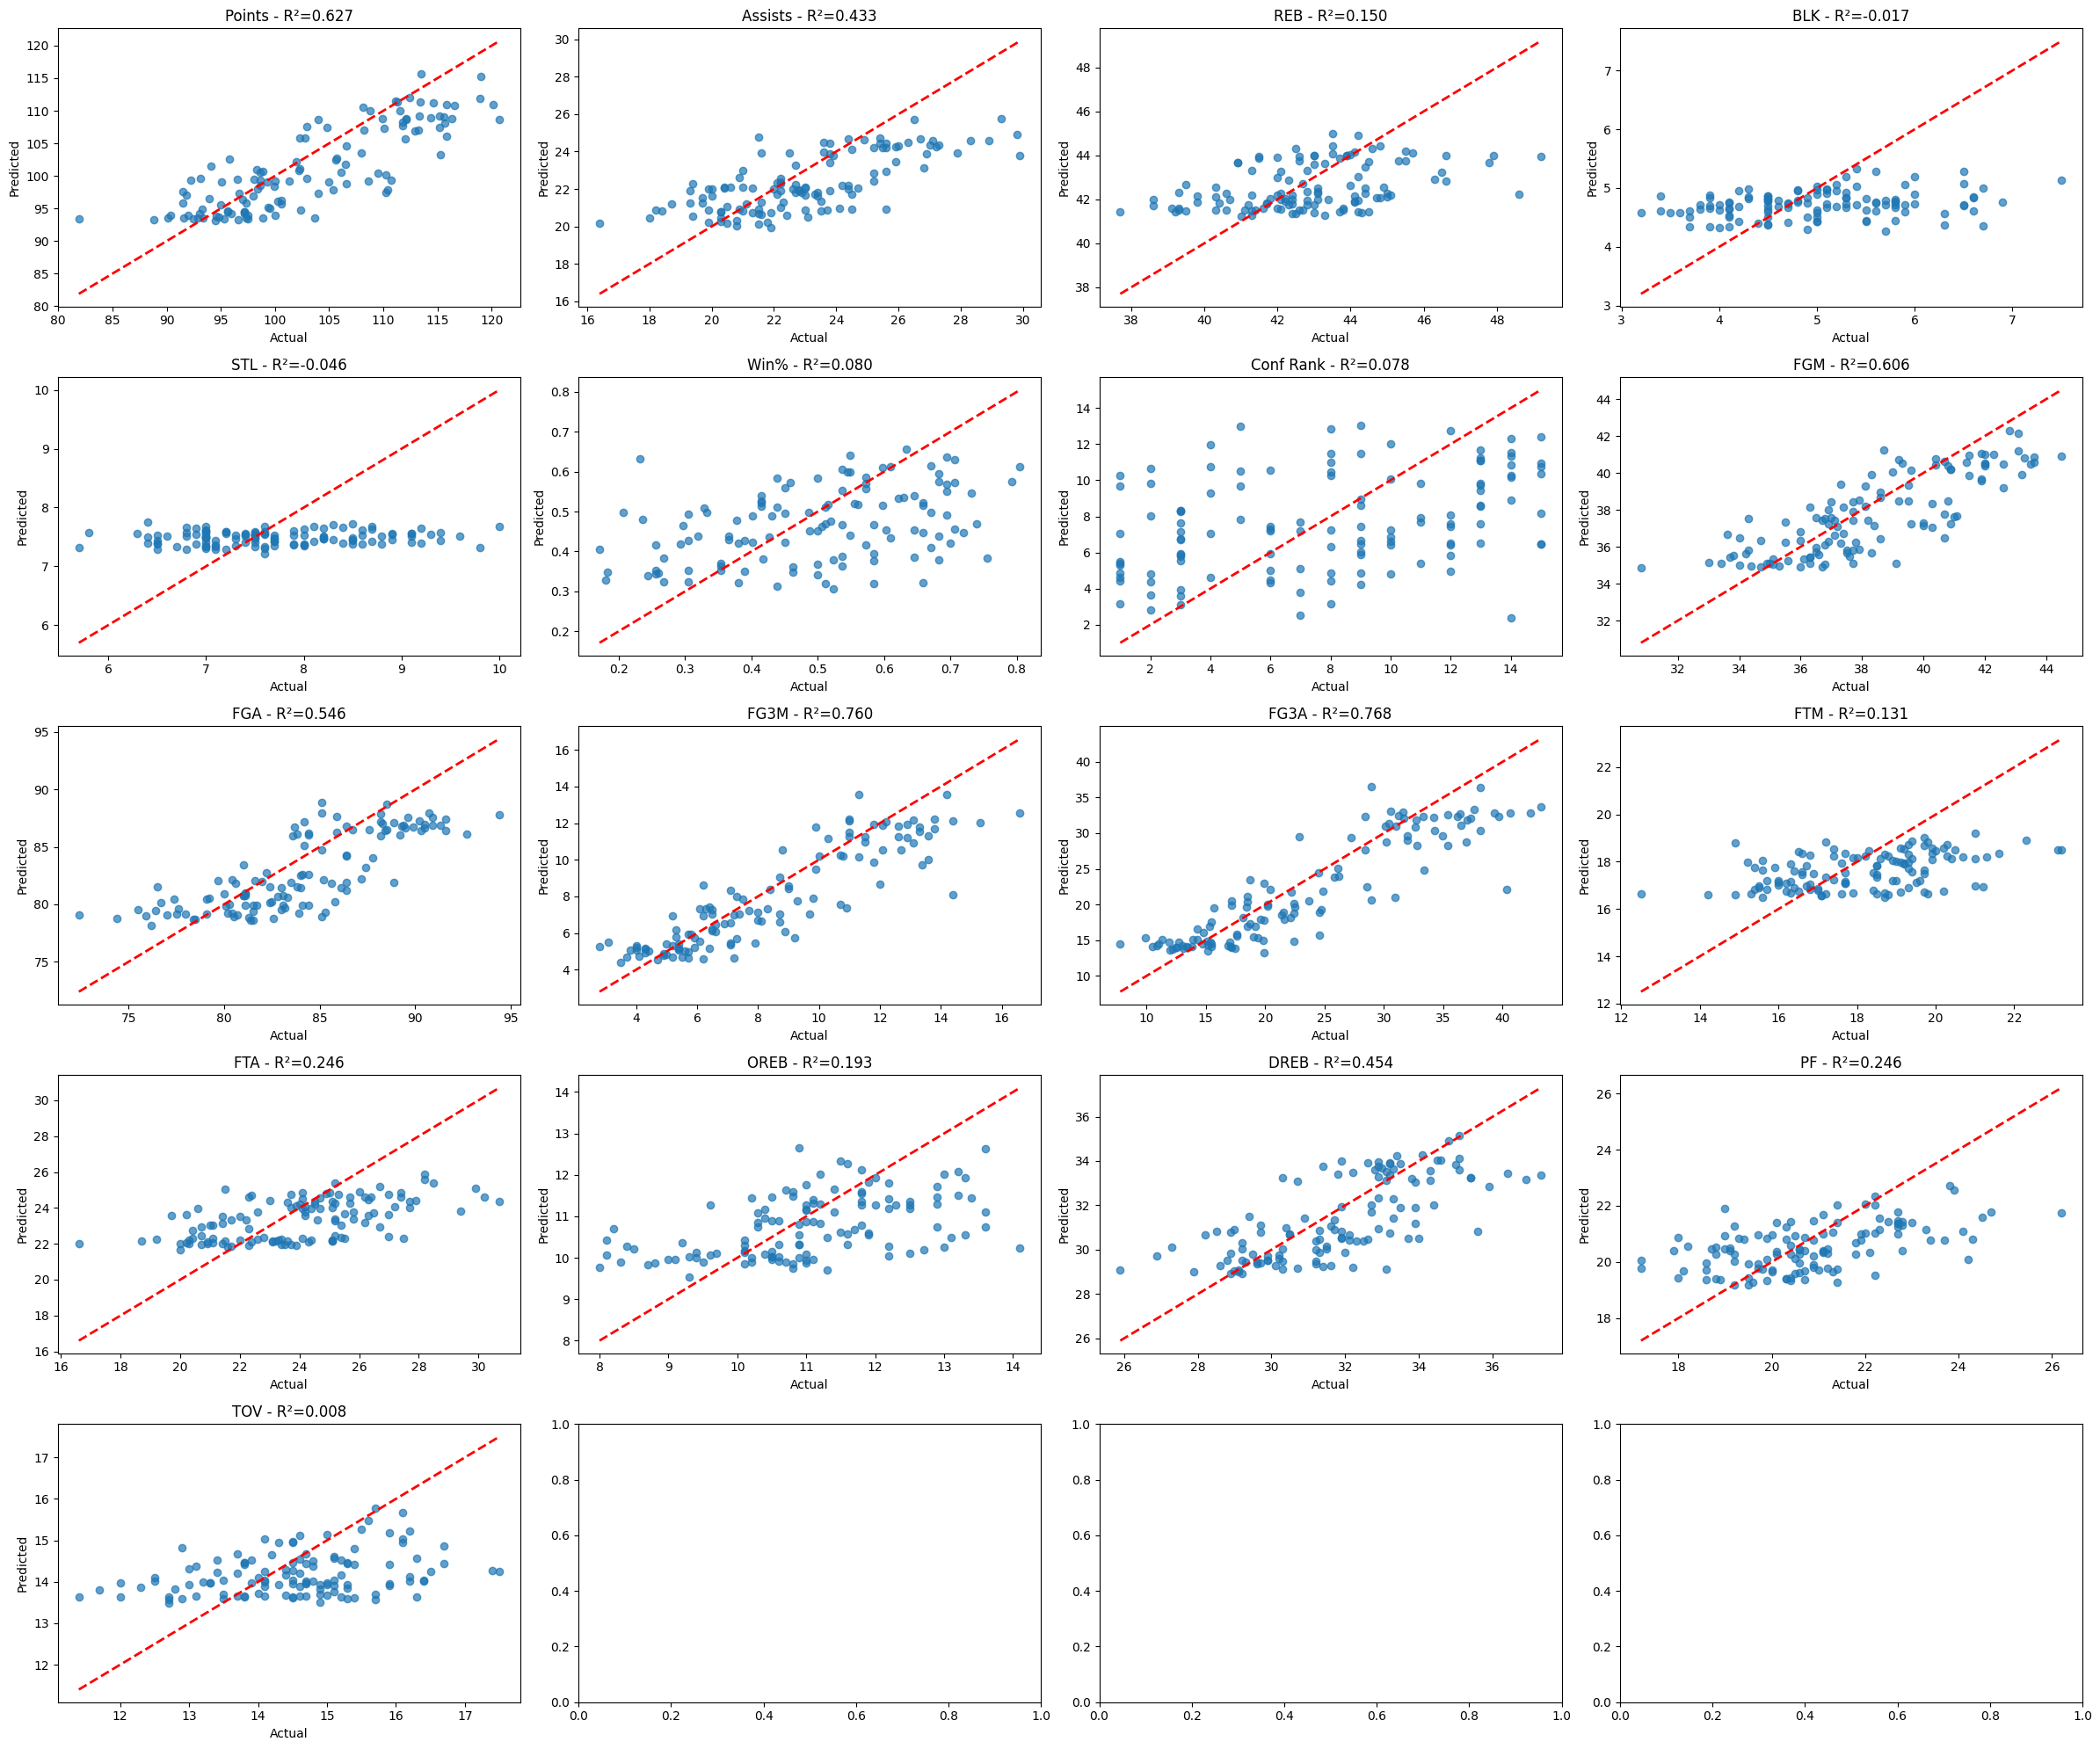

In [ ]:
def create_cnn_nba_model(input_shape, output_dim):
    """
    CNN-based architecture with advanced multi-scale pattern recognition,
    attention mechanisms, and residual connections for superior NBA team performance prediction
    """
    # Input: (batch_size, 8 players, num_stats)
    inputs = Input(shape=input_shape[1:])

    # Branch 1: Multi-scale CNN with enhanced depth and LeakyReLU
    # Small kernel - captures pairs/trios of players
    conv1 = Conv1D(filters=192, kernel_size=2, padding='same')(inputs)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(filters=384, kernel_size=2, padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = SpatialDropout1D(0.3)(conv1)

    # Medium kernel - captures larger player groups
    conv2 = Conv1D(filters=192, kernel_size=4, padding='same')(inputs)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(filters=384, kernel_size=4, padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = SpatialDropout1D(0.3)(conv2)

    # Large kernel - captures team-wide patterns
    conv3 = Conv1D(filters=192, kernel_size=6, padding='same')(inputs)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(filters=384, kernel_size=6, padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = SpatialDropout1D(0.3)(conv3)

    # Extra-large kernel - captures full team dynamics
    conv4 = Conv1D(filters=192, kernel_size=8, padding='same')(inputs)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(filters=384, kernel_size=8, padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = SpatialDropout1D(0.3)(conv4)

    # Enhanced global pooling for each branch
    global_max1 = GlobalMaxPooling1D()(conv1)
    global_avg1 = GlobalAveragePooling1D()(conv1)

    global_max2 = GlobalMaxPooling1D()(conv2)
    global_avg2 = GlobalAveragePooling1D()(conv2)

    global_max3 = GlobalMaxPooling1D()(conv3)
    global_avg3 = GlobalAveragePooling1D()(conv3)

    global_max4 = GlobalMaxPooling1D()(conv4)
    global_avg4 = GlobalAveragePooling1D()(conv4)

    # Branch 2: Advanced statistical aggregations
    player_mean = Lambda(lambda x: tf.reduce_mean(x, axis=1))(inputs)
    player_max = Lambda(lambda x: tf.reduce_max(x, axis=1))(inputs)
    player_min = Lambda(lambda x: tf.reduce_min(x, axis=1))(inputs)
    player_std = Lambda(lambda x: tf.math.reduce_std(x, axis=1))(inputs)
    player_var = Lambda(lambda x: tf.math.reduce_variance(x, axis=1))(inputs)

    stats_branch = Concatenate()([player_mean, player_max, player_min, player_std, player_var])
    stats_branch = Dense(256)(stats_branch)
    stats_branch = LeakyReLU(alpha=0.01)(stats_branch)
    stats_branch = BatchNormalization()(stats_branch)
    stats_branch = Dropout(0.4)(stats_branch)

    # Attention mechanism for statistical features
    stats_attention = Dense(256)(stats_branch)
    stats_attention = LeakyReLU(alpha=0.01)(stats_attention)
    stats_attention = Dense(256, activation='sigmoid')(stats_attention)
    stats_branch = Multiply()([stats_branch, stats_attention])

    # Combine all features with enhanced capacity
    combined = Concatenate()([
        global_max1, global_avg1,
        global_max2, global_avg2,
        global_max3, global_avg3,
        global_max4, global_avg4,
        stats_branch
    ])

    # Deep fully connected layers with residual connections
    x = Dense(768)(combined)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # First residual block
    x_residual1 = Dense(512)(x)
    x_residual1 = LeakyReLU(alpha=0.01)(x_residual1)
    x_residual1 = BatchNormalization()(x_residual1)
    x_residual1 = Dropout(0.4)(x_residual1)
    x = Add()([x, x_residual1])  # Skip connection

    x = Dense(384)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second residual block
    x_residual2 = Dense(384)(x)
    x_residual2 = LeakyReLU(alpha=0.01)(x_residual2)
    x_residual2 = BatchNormalization()(x_residual2)
    x_residual2 = Dropout(0.3)(x_residual2)
    x = Add()([x, x_residual2])  # Skip connection

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.1)(x)

    # Output layer
    outputs = Dense(output_dim, activation='linear', name='team_performance')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Enhanced optimizer with gradient clipping
    optimizer = Adam(
        learning_rate=0.0005,  # Slightly lower for stability
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss='mse',  # More robust loss
        metrics=['mae', 'mse']
    )

    return model

# Create enhanced model
print("🚀 Creating enhanced CNN-based NBA model...")
cnn_model = create_cnn_nba_model(X_train_final.shape, Y_train_final.shape[1])
cnn_model.summary()

# Advanced callbacks with improved parameters
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=35,  # Increased patience for complex model
        restore_best_weights=True,
        verbose=1,
        min_delta=1e-5
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More aggressive reduction
        patience=12,
        min_lr=1e-7,
        verbose=1,
        cooldown=8
    ),
    ModelCheckpoint(
        'cnn_nba_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# Train with higher batch size for GPU efficiency
print("\n🏀 Training improved NBA model...")
history = cnn_model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=400,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



# Make predictions on test set
print("\n🔮 Making predictions on test set...")
Y_pred_scaled = cnn_model.predict(X_test_scaled)
print("Predicted all Y shape")
print(Y_pred_scaled.shape)

# Inverse transform to get original scale
Y_test_original = y_scaler.inverse_transform(Y_test_scaled)
Y_pred_original = y_scaler.inverse_transform(Y_pred_scaled)

# Calculate metrics
mae = mean_absolute_error(Y_test_original, Y_pred_original)
mse = mean_squared_error(Y_test_original, Y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_original, Y_pred_original)

print("\n" + "="*60)
print("🎯 TEST SET RESULTS - HOW FAR FROM TRUTH")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variance")

# Team performance labels (what the model predicts)
performance_labels = [
    "Points", "Assists", "Rebounds", "Blocks", "Steals",
    "Win %", "Conf Rank", "FGM", "FGA", "3PM", "3PA",
    "FTM", "FTA", "OREB", "DREB", "Fouls", "Turnovers"
]

print("\n📊 DETAILED RESULTS BY METRIC:")
print("-" * 60)
for i, label in enumerate(performance_labels):
    actual_values = Y_test_original[:, i]
    predicted_values = Y_pred_original[:, i]

    metric_mae = mean_absolute_error(actual_values, predicted_values)
    metric_r2 = r2_score(actual_values, predicted_values)

    print(f"{label:12s}: MAE={metric_mae:6.2f}, R²={metric_r2:6.3f}")

print("\n🏆 SAMPLE TEAM PREDICTIONS:")
print("-" * 80)
# Get sample team names from test data
sample_teams = list(data.keys())[:25]  # First 5 teams

for i, team_key in enumerate(sample_teams):
    team_name = team_key.split('_')[0]
    print(f"\n{team_name} (2023 season):")
    print("Metric          Actual    Predicted    Error")
    print("-" * 45)

    for j, label in enumerate(performance_labels):  # Show first 8 metrics
        actual = Y_test_original[i, j]
        predicted = Y_pred_original[i, j]
        error = abs(actual - predicted)
        print(f"{label:12s}: {actual:8.1f} {predicted:10.1f} {error:8.1f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot for key metrics
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
key_metrics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Points, Assists, REB, BLK, STL, Win%, Conf Rank, FGM, FGA, FG3M, FG3A, FTM, FTA, OREB, DREB, PF, TOV
metric_names = ["Points", "Assists", "REB", "BLK", "STL", "Win%", "Conf Rank", "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "OREB", "DREB", "PF", "TOV"]

for idx, (metric_idx, ax) in enumerate(zip(key_metrics, axes.flat)):
    actual = Y_test_original[:, metric_idx]
    predicted = Y_pred_original[:, metric_idx]

    ax.scatter(actual, predicted, alpha=0.7)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{metric_names[idx]} - R²={r2_score(actual, predicted):.3f}')

plt.tight_layout()
plt.show()


## Multi-Head Attention Model

**Model -**

Input: player stats (batch, 8 players, features).

Two multi-head self-attention layers with residuals + layer norm.

Global average pooling → team representation.

MLP head with residual block and dropout.

Output: 17 team performance metrics (linear).

Loss: MSE, metric: MAE.

Optimizer: Adam with gradient clipping.

**Training -**

400 epochs, early stopping, LR reduction, model checkpoint.

**Evaluation -**

Predict on test set.

Calculate MAE, RMSE, R² overall and per metric.

Show sample team predictions with actual vs predicted.

**Visualization -**

Training loss & MAE curves.

Actual vs predicted scatter plots for key metrics.









🧠 Creating attention-based NBA model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     63,006 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 30)     │          0 │ input_layer_1[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 8, 30)     │         60 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     15,774 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 30)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │     15,872 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dropout_12[0][0], │
│                     │                   │            │ dropout_13[0][0]

 Total params: 338,757 (1.29 MB)

 Trainable params: 336,453 (1.28 MB)

 Non-trainable params: 2,304 (9.00 KB)


🏀 Training attention-based NBA model...
Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - loss: 1.2519 - mae: 0.8664
Epoch 1: val_loss improved from inf to 0.21097, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 1.2427 - mae: 0.8633 - val_loss: 0.2110 - val_mae: 0.4081 - learning_rate: 0.0010
Epoch 2/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6754 - mae: 0.6430 
Epoch 2: val_loss improved from 0.21097 to 0.17864, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6576 - mae: 0.6343 - val_loss: 0.1786 - val_mae: 0.3671 - learning_rate: 0.0010
Epoch 3/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4563 - mae: 0.5291 
Epoch 3: val_loss improved from 0.17864 to 0.15101, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4498 - mae: 0.5248 - val_loss: 0.1510 - val_mae: 0.3272 - learning_rate: 0.0010
Epoch 4/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3441 - mae: 0.4613 
Epoch 4: val_loss improved from 0.15101 to 0.12317, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3398 - mae: 0.4584 - val_loss: 0.1232 - val_mae: 0.2906 - learning_rate: 0.0010
Epoch 5/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2587 - mae: 0.3955 
Epoch 5: val_loss improved from 0.12317 to 0.09016, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2539 - mae: 0.3922 - val_loss: 0.0902 - val_mae: 0.2418 - learning_rate: 0.0010
Epoch 6/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1946 - mae: 0.3471 
Epoch 6: val_loss improved from 0.09016 to 0.06598, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1928 - mae: 0.3454 - val_loss: 0.0660 - val_mae: 0.2042 - learning_rate: 0.0010
Epoch 7/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1644 - mae: 0.3165 
Epoch 7: val_loss improved from 0.06598 to 0.06387, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1632 - mae: 0.3156 - val_loss: 0.0639 - val_mae: 0.2014 - learning_rate: 0.0010
Epoch 8/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1537 - mae: 0.3066 
Epoch 8: val_loss improved from 0.06387 to 0.05372, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1524 - mae: 0.3056 - val_loss: 0.0537 - val_mae: 0.1808 - learning_rate: 0.0010
Epoch 9/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1292 - mae: 0.2840 
Epoch 9: val_loss improved from 0.05372 to 0.05116, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1284 - mae: 0.2832 - val_loss: 0.0512 - val_mae: 0.1756 - learning_rate: 0.0010
Epoch 10/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1134 - mae: 0.2652 
Epoch 10: val_loss improved from 0.05116 to 0.05092, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1126 - mae: 0.2642 - val_loss: 0.0509 - val_mae: 0.1749 - learning_rate: 0.0010
Epoch 11/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1017 - mae: 0.2504 
Epoch 11: val_loss improved from 0.05092 to 0.04985, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1015 - mae: 0.2501 - val_loss: 0.0498 - val_mae: 0.1736 - learning_rate: 0.0010
Epoch 12/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0968 - mae: 0.2443 
Epoch 12: val_loss improved from 0.04985 to 0.04672, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0962 - mae: 0.2436 - val_loss: 0.0467 - val_mae: 0.1690 - learning_rate: 0.0010
Epoch 13/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0887 - mae: 0.2357 
Epoch 13: val_loss improved from 0.04672 to 0.04600, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0888 - mae: 0.2355 - val_loss: 0.0460 - val_mae: 0.1685 - learning_rate: 0.0010
Epoch 14/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - mae: 0.2192 
Epoch 14: val_loss improved from 0.04600 to 0.04223, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0774 - mae: 0.2198 - val_loss: 0.0422 - val_mae: 0.1609 - learning_rate: 0.0010
Epoch 15/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0739 - mae: 0.2130 
Epoch 15: val_loss did not improve from 0.04223
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0742 - mae: 0.2134 - val_loss: 0.0453 - val_mae: 0.1664 - learning_rate: 0.0010
Epoch 16/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 - mae: 0.2135 
Epoch 16: val_loss did not improve from 0.04223
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0738 - mae: 0.2131 - val_loss: 0.0489 - val_mae: 0.1738 - learning_rate: 0.0010
Epoch 17/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0690 - mae: 0.2059 
Epoch 17: val_loss did not improve from 0.04223
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0689 - mae: 0.2057 - val_loss: 0.0463 - val_mae: 0.1677 - learning_rate: 0.0010
Epoch 18/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0640 - mae: 0.1993 
Epoch 18: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0588 - mae: 0.1902 - val_loss: 0.0402 - val_mae: 0.1548 - learning_rate: 0.0010
Epoch 21/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - mae: 0.1850 
Epoch 21: val_loss did not improve from 0.04023
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0560 - mae: 0.1853 - val_loss: 0.0423 - val_mae: 0.1576 - learning_rate: 0.0010
Epoch 22/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0564 - mae: 0.1863 
Epoch 22: val_loss did not improve from 0.04023
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0562 - mae: 0.1860 - val_loss: 0.0438 - val_mae: 0.1617 - learning_rate: 0.0010
Epoch 23/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - mae: 0.1791 
Epoch 23: val_loss improved from 0.04023 to 0.03806, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0522 - mae: 0.1792 - val_loss: 0.0381 - val_mae: 0.1505 - learning_rate: 0.0010
Epoch 24/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - mae: 0.1778 
Epoch 24: val_loss improved from 0.03806 to 0.03414, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0513 - mae: 0.1776 - val_loss: 0.0341 - val_mae: 0.1426 - learning_rate: 0.0010
Epoch 25/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - mae: 0.1721 
Epoch 25: val_loss did not improve from 0.03414
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0486 - mae: 0.1725 - val_loss: 0.0371 - val_mae: 0.1484 - learning_rate: 0.0010
Epoch 26/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - mae: 0.1684 
Epoch 26: val_loss did not improve from 0.03414
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0467 - mae: 0.1689 - val_loss: 0.0373 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 27/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 - mae: 0.1692 
Epoch 27: val_loss did not improve from 0.03414
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0469 - mae: 0.1691 - val_loss: 0.0356 - val_mae: 0.1454 - learning_rate: 0.0010
Epoch 28/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - mae: 0.1670 
Epoch 28: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0399 - mae: 0.1557 - val_loss: 0.0337 - val_mae: 0.1399 - learning_rate: 0.0010
Epoch 35/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - mae: 0.1484 
Epoch 35: val_loss improved from 0.03373 to 0.03304, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362 - mae: 0.1488 - val_loss: 0.0330 - val_mae: 0.1385 - learning_rate: 0.0010
Epoch 36/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - mae: 0.1472 
Epoch 36: val_loss did not improve from 0.03304
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0360 - mae: 0.1475 - val_loss: 0.0331 - val_mae: 0.1390 - learning_rate: 0.0010
Epoch 37/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357 - mae: 0.1469 
Epoch 37: val_loss improved from 0.03304 to 0.03072, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0358 - mae: 0.1471 - val_loss: 0.0307 - val_mae: 0.1336 - learning_rate: 0.0010
Epoch 38/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357 - mae: 0.1471 
Epoch 38: val_loss did not improve from 0.03072
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0357 - mae: 0.1473 - val_loss: 0.0320 - val_mae: 0.1364 - learning_rate: 0.0010
Epoch 39/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0335 - mae: 0.1433 
Epoch 39: val_loss did not improve from 0.03072
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0337 - mae: 0.1436 - val_loss: 0.0310 - val_mae: 0.1340 - learning_rate: 0.0010
Epoch 40/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - mae: 0.1460 
Epoch 40: val_loss improved from 0.03072 to 0.03012, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0348 - mae: 0.1459 - val_loss: 0.0301 - val_mae: 0.1316 - learning_rate: 0.0010
Epoch 41/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - mae: 0.1444 
Epoch 41: val_loss did not improve from 0.03012
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342 - mae: 0.1441 - val_loss: 0.0304 - val_mae: 0.1327 - learning_rate: 0.0010
Epoch 42/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - mae: 0.1436 
Epoch 42: val_loss improved from 0.03012 to 0.02936, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0335 - mae: 0.1432 - val_loss: 0.0294 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 43/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - mae: 0.1387 
Epoch 43: val_loss improved from 0.02936 to 0.02882, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0317 - mae: 0.1389 - val_loss: 0.0288 - val_mae: 0.1300 - learning_rate: 0.0010
Epoch 44/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 - mae: 0.1398 
Epoch 44: val_loss did not improve from 0.02882
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - mae: 0.1397 - val_loss: 0.0297 - val_mae: 0.1318 - learning_rate: 0.0010
Epoch 45/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321 - mae: 0.1408 
Epoch 45: val_loss did not improve from 0.02882
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0318 - mae: 0.1401 - val_loss: 0.0301 - val_mae: 0.1328 - learning_rate: 0.0010
Epoch 46/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - mae: 0.1377 
Epoch 46: val_loss improved from 0.02882 to 0.02767, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0311 - mae: 0.1376 - val_loss: 0.0277 - val_mae: 0.1268 - learning_rate: 0.0010
Epoch 47/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - mae: 0.1352 
Epoch 47: val_loss improved from 0.02767 to 0.02749, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298 - mae: 0.1350 - val_loss: 0.0275 - val_mae: 0.1266 - learning_rate: 0.0010
Epoch 48/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 - mae: 0.1395 
Epoch 48: val_loss did not improve from 0.02749
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - mae: 0.1392 - val_loss: 0.0277 - val_mae: 0.1270 - learning_rate: 0.0010
Epoch 49/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 - mae: 0.1318 
Epoch 49: val_loss improved from 0.02749 to 0.02729, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - mae: 0.1326 - val_loss: 0.0273 - val_mae: 0.1259 - learning_rate: 0.0010
Epoch 50/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - mae: 0.1360 
Epoch 50: val_loss improved from 0.02729 to 0.02723, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0300 - mae: 0.1357 - val_loss: 0.0272 - val_mae: 0.1263 - learning_rate: 0.0010
Epoch 51/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - mae: 0.1339 
Epoch 51: val_loss improved from 0.02723 to 0.02641, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0297 - mae: 0.1338 - val_loss: 0.0264 - val_mae: 0.1244 - learning_rate: 0.0010
Epoch 52/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - mae: 0.1331 
Epoch 52: val_loss improved from 0.02641 to 0.02620, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0286 - mae: 0.1327 - val_loss: 0.0262 - val_mae: 0.1247 - learning_rate: 0.0010
Epoch 53/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 - mae: 0.1310 
Epoch 53: val_loss improved from 0.02620 to 0.02567, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0284 - mae: 0.1309 - val_loss: 0.0257 - val_mae: 0.1233 - learning_rate: 0.0010
Epoch 54/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - mae: 0.1305 
Epoch 54: val_loss improved from 0.02567 to 0.02553, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0278 - mae: 0.1306 - val_loss: 0.0255 - val_mae: 0.1223 - learning_rate: 0.0010
Epoch 55/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - mae: 0.1331 
Epoch 55: val_loss did not improve from 0.02553
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289 - mae: 0.1324 - val_loss: 0.0259 - val_mae: 0.1231 - learning_rate: 0.0010
Epoch 56/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - mae: 0.1284 
Epoch 56: val_loss did not improve from 0.02553
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0272 - mae: 0.1283 - val_loss: 0.0258 - val_mae: 0.1227 - learning_rate: 0.0010
Epoch 57/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - mae: 0.1285 
Epoch 57: val_loss did not improve from 0.02553
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0271 - mae: 0.1283 - val_loss: 0.0261 - val_mae: 0.1236 - learning_rate: 0.0010
Epoch 58/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - mae: 0.1288 
Epoch 58: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0272 - mae: 0.1284 - val_loss: 0.0250 - val_mae: 0.1213 - learning_rate: 0.0010
Epoch 59/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - mae: 0.1280 
Epoch 59: val_loss did not improve from 0.02497
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0268 - mae: 0.1275 - val_loss: 0.0257 - val_mae: 0.1233 - learning_rate: 0.0010
Epoch 60/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262 - mae: 0.1258 
Epoch 60: val_loss did not improve from 0.02497
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0263 - mae: 0.1260 - val_loss: 0.0256 - val_mae: 0.1229 - learning_rate: 0.0010
Epoch 61/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mae: 0.1260 
Epoch 61: val_loss did not improve from 0.02497
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - mae: 0.1257 - val_loss: 0.0255 - val_mae: 0.1220 - learning_rate: 0.0010
Epoch 62/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - mae: 0.1245 
Epoch 62: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257 - mae: 0.1245 - val_loss: 0.0249 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 63/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - mae: 0.1244 
Epoch 63: val_loss improved from 0.02493 to 0.02490, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0257 - mae: 0.1244 - val_loss: 0.0249 - val_mae: 0.1205 - learning_rate: 0.0010
Epoch 64/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - mae: 0.1196 
Epoch 64: val_loss improved from 0.02490 to 0.02453, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0239 - mae: 0.1201 - val_loss: 0.0245 - val_mae: 0.1195 - learning_rate: 0.0010
Epoch 65/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mae: 0.1194 
Epoch 65: val_loss improved from 0.02453 to 0.02443, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0240 - mae: 0.1199 - val_loss: 0.0244 - val_mae: 0.1198 - learning_rate: 0.0010
Epoch 66/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - mae: 0.1253 
Epoch 66: val_loss did not improve from 0.02443
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - mae: 0.1250 - val_loss: 0.0247 - val_mae: 0.1206 - learning_rate: 0.0010
Epoch 67/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - mae: 0.1205 
Epoch 67: val_loss did not improve from 0.02443
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 - mae: 0.1205 - val_loss: 0.0250 - val_mae: 0.1219 - learning_rate: 0.0010
Epoch 68/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - mae: 0.1246 
Epoch 68: val_loss improved from 0.02443 to 0.02443, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0253 - mae: 0.1241 - val_loss: 0.0244 - val_mae: 0.1202 - learning_rate: 0.0010
Epoch 69/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mae: 0.1205 
Epoch 69: val_loss improved from 0.02443 to 0.02354, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0240 - mae: 0.1205 - val_loss: 0.0235 - val_mae: 0.1171 - learning_rate: 0.0010
Epoch 70/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - mae: 0.1193 
Epoch 70: val_loss did not improve from 0.02354
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0240 - mae: 0.1196 - val_loss: 0.0242 - val_mae: 0.1187 - learning_rate: 0.0010
Epoch 71/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mae: 0.1177 
Epoch 71: val_loss did not improve from 0.02354
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0233 - mae: 0.1180 - val_loss: 0.0241 - val_mae: 0.1191 - learning_rate: 0.0010
Epoch 72/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.1220 
Epoch 72: val_loss did not improve from 0.02354
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0241 - mae: 0.1217 - val_loss: 0.0238 - val_mae: 0.1184 - learning_rate: 0.0010
Epoch 73/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - mae: 0.1179 
Epoch 73: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231 - mae: 0.1180 - val_loss: 0.0235 - val_mae: 0.1176 - learning_rate: 0.0010
Epoch 75/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - mae: 0.1176 
Epoch 75: val_loss improved from 0.02350 to 0.02329, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229 - mae: 0.1176 - val_loss: 0.0233 - val_mae: 0.1170 - learning_rate: 0.0010
Epoch 76/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - mae: 0.1185 
Epoch 76: val_loss improved from 0.02329 to 0.02328, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234 - mae: 0.1185 - val_loss: 0.0233 - val_mae: 0.1165 - learning_rate: 0.0010
Epoch 77/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mae: 0.1183 
Epoch 77: val_loss improved from 0.02328 to 0.02288, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238 - mae: 0.1183 - val_loss: 0.0229 - val_mae: 0.1158 - learning_rate: 0.0010
Epoch 78/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - mae: 0.1179 
Epoch 78: val_loss improved from 0.02288 to 0.02239, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0233 - mae: 0.1177 - val_loss: 0.0224 - val_mae: 0.1149 - learning_rate: 0.0010
Epoch 79/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - mae: 0.1168 
Epoch 79: val_loss did not improve from 0.02239
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228 - mae: 0.1171 - val_loss: 0.0232 - val_mae: 0.1176 - learning_rate: 0.0010
Epoch 80/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - mae: 0.1184 
Epoch 80: val_loss improved from 0.02239 to 0.02221, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232 - mae: 0.1183 - val_loss: 0.0222 - val_mae: 0.1147 - learning_rate: 0.0010
Epoch 81/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - mae: 0.1157 
Epoch 81: val_loss did not improve from 0.02221
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - mae: 0.1158 - val_loss: 0.0233 - val_mae: 0.1177 - learning_rate: 0.0010
Epoch 82/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - mae: 0.1175 
Epoch 82: val_loss did not improve from 0.02221
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - mae: 0.1172 - val_loss: 0.0227 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 83/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mae: 0.1152 
Epoch 83: val_loss did not improve from 0.02221
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223 - mae: 0.1154 - val_loss: 0.0226 - val_mae: 0.1161 - learning_rate: 0.0010
Epoch 84/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mae: 0.1170 
Epoch 84: v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0224 - mae: 0.1163 - val_loss: 0.0221 - val_mae: 0.1147 - learning_rate: 0.0010
Epoch 90/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - mae: 0.1137 
Epoch 90: val_loss improved from 0.02212 to 0.02113, saving model to attention_nba_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - mae: 0.1137 - val_loss: 0.0211 - val_mae: 0.1118 - learning_rate: 0.0010
Epoch 91/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mae: 0.1144 
Epoch 91: val_loss did not improve from 0.02113
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - mae: 0.1143 - val_loss: 0.0223 - val_mae: 0.1151 - learning_rate: 0.0010
Epoch 92/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - mae: 0.1134 
Epoch 92: val_loss did not improve from 0.02113
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mae: 0.1132 - val_loss: 0.0213 - val_mae: 0.1119 - learning_rate: 0.0010
Epoch 93/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - mae: 0.1125 
Epoch 93: val_loss did not improve from 0.02113
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - mae: 0.1126 - val_loss: 0.0215 - val_mae: 0.1118 - learning_rate: 0.0010
Epoch 94/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mae: 0.1125 
Epoch 94: v

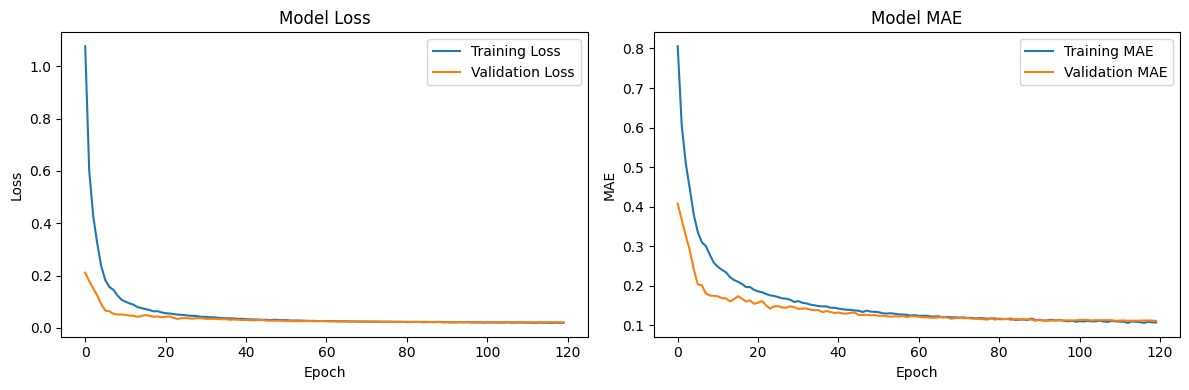

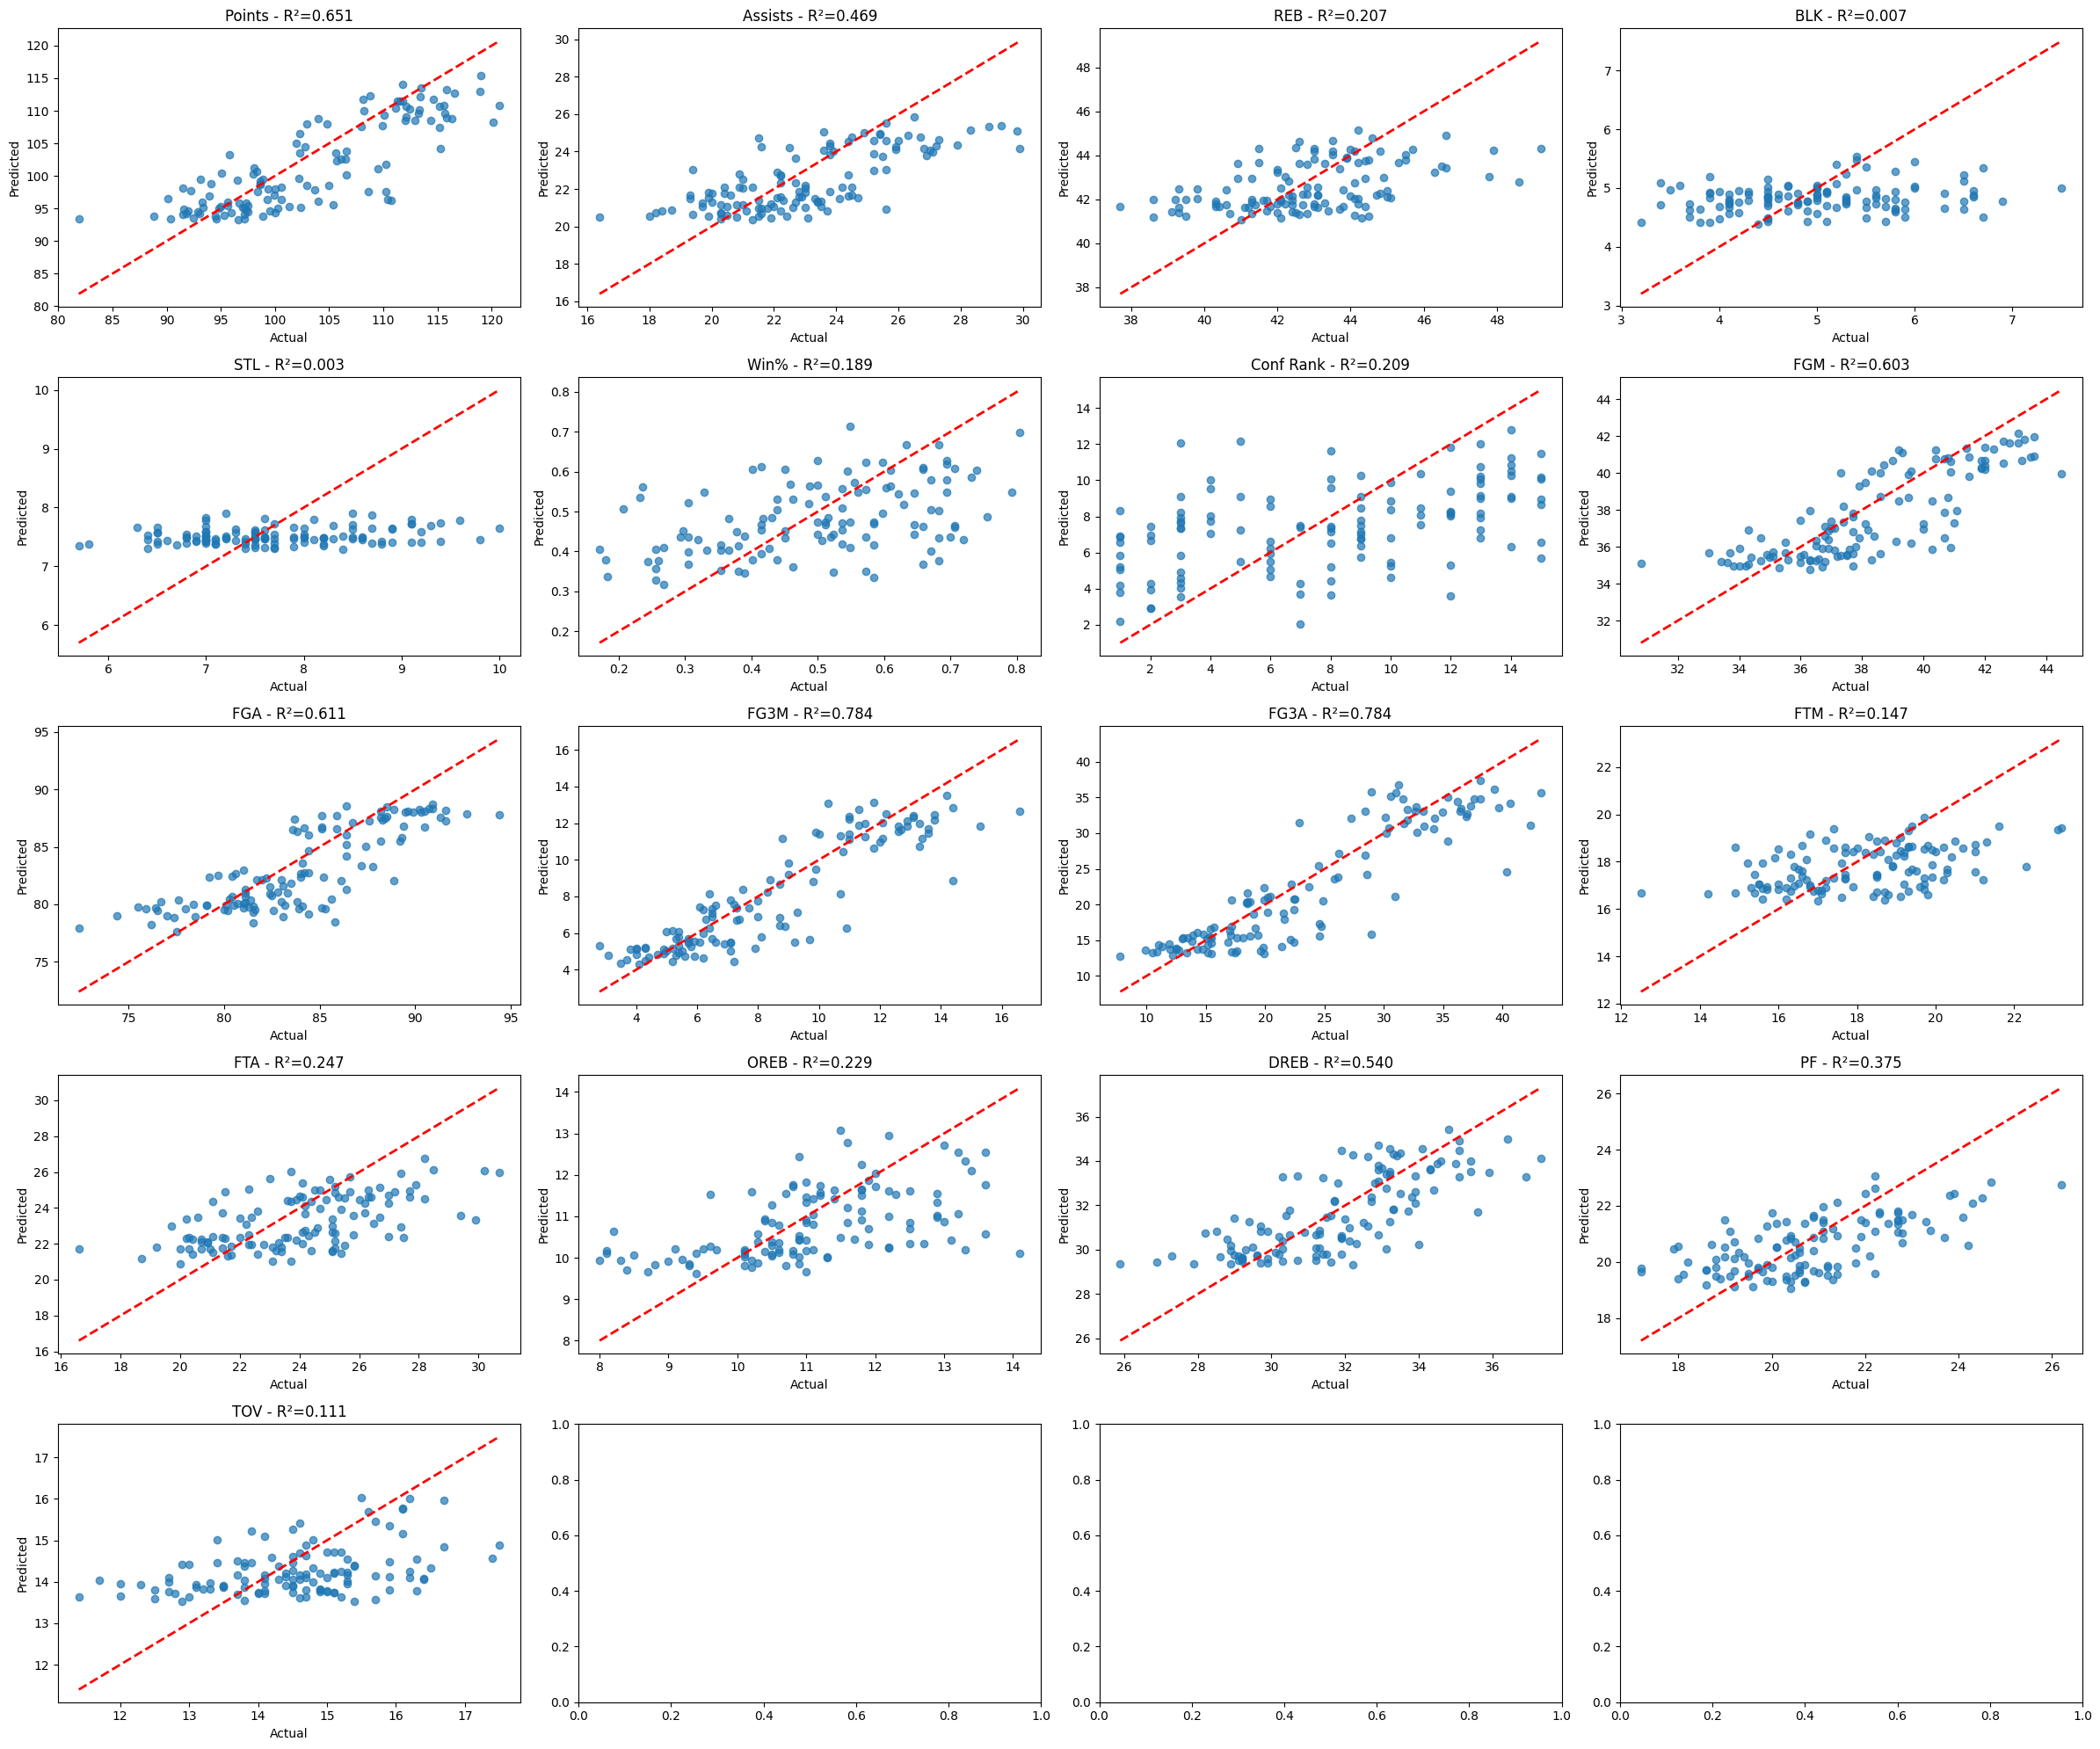

In [ ]:
def create_attention_nba_model(input_shape, output_dim):
    """
    Uses multi-head attention to learn which players are most important
    for predicting different team performance metrics
    """
    # Input: (batch_size, 8 players, num_stats)
    inputs = Input(shape=input_shape[1:])

    # Multi-Head Attention Block 1
    # This learns which players to focus on for team performance
    attn_output1 = MultiHeadAttention(
        num_heads=8,
        key_dim=64,
        dropout=0.1
    )(inputs, inputs)  # Self-attention

    # Add residual connection and layer norm
    attn_output1 = Add()([inputs, attn_output1])
    attn_output1 = LayerNormalization()(attn_output1)

    # Multi-Head Attention Block 2
    # Second attention layer to capture more complex player relationships
    attn_output2 = MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        dropout=0.1
    )(attn_output1, attn_output1)

    attn_output2 = Add()([attn_output1, attn_output2])
    attn_output2 = LayerNormalization()(attn_output2)

    # Global Average Pooling to aggregate attended player features
    # This creates a single team representation from all players
    team_representation = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attn_output2)

    # MLP Head for final prediction
    # Deep MLP to map team representation to performance metrics
    x = Dense(512, activation='relu')(team_representation)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Residual block in MLP
    x_residual = Dense(256, activation='relu')(x)
    x_residual = BatchNormalization()(x_residual)
    x_residual = Dropout(0.2)(x_residual)
    x = Add()([x, x_residual])

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Output layer - 17 team performance metrics
    outputs = Dense(output_dim, activation='linear', name='team_performance')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizer with gradient clipping for stable attention training
    optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0  # Gradient clipping for attention stability
    )

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model

# Create attention-based model
print("🧠 Creating attention-based NBA model...")
attention_model = create_attention_nba_model(X_train_final.shape, Y_train_final.shape[1])
attention_model.summary()

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=12,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'attention_nba_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the attention model
print("\n🏀 Training attention-based NBA model...")
history = attention_model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=400,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


# Make predictions on test set
print("\n🔮 Making predictions on test set...")
Y_pred_scaled = attention_model.predict(X_test_scaled)
print("Predicted all Y shape")
print(Y_pred_scaled.shape)

# Inverse transform to get original scale
Y_test_original = y_scaler.inverse_transform(Y_test_scaled)
Y_pred_original = y_scaler.inverse_transform(Y_pred_scaled)

# Calculate metrics
mae = mean_absolute_error(Y_test_original, Y_pred_original)
mse = mean_squared_error(Y_test_original, Y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_original, Y_pred_original)

print("\n" + "="*60)
print("🎯 TEST SET RESULTS - HOW FAR FROM TRUTH")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variance")

# Team performance labels (what the model predicts)
performance_labels = [
    "Points", "Assists", "Rebounds", "Blocks", "Steals",
    "Win %", "Conf Rank", "FGM", "FGA", "3PM", "3PA",
    "FTM", "FTA", "OREB", "DREB", "Fouls", "Turnovers"
]

print("\n📊 DETAILED RESULTS BY METRIC:")
print("-" * 60)
for i, label in enumerate(performance_labels):
    actual_values = Y_test_original[:, i]
    predicted_values = Y_pred_original[:, i]

    metric_mae = mean_absolute_error(actual_values, predicted_values)
    metric_r2 = r2_score(actual_values, predicted_values)

    print(f"{label:12s}: MAE={metric_mae:6.2f}, R²={metric_r2:6.3f}")

print("\n🏆 SAMPLE TEAM PREDICTIONS:")
print("-" * 80)
# Get sample team names from test data
sample_teams = list(data.keys())[:25]  # First 5 teams

for i, team_key in enumerate(sample_teams):
    team_name = team_key.split('_')[0]
    print(f"\n{team_name} (2023 season):")
    print("Metric          Actual    Predicted    Error")
    print("-" * 45)

    for j, label in enumerate(performance_labels):  # Show first 8 metrics
        actual = Y_test_original[i, j]
        predicted = Y_pred_original[i, j]
        error = abs(actual - predicted)
        print(f"{label:12s}: {actual:8.1f} {predicted:10.1f} {error:8.1f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot for key metrics
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
key_metrics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Points, Assists, REB, BLK, STL, Win%, Conf Rank, FGM, FGA, FG3M, FG3A, FTM, FTA, OREB, DREB, PF, TOV
metric_names = ["Points", "Assists", "REB", "BLK", "STL", "Win%", "Conf Rank", "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "OREB", "DREB", "PF", "TOV"]

for idx, (metric_idx, ax) in enumerate(zip(key_metrics, axes.flat)):
    actual = Y_test_original[:, metric_idx]
    predicted = Y_pred_original[:, metric_idx]

    ax.scatter(actual, predicted, alpha=0.7)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{metric_names[idx]} - R²={r2_score(actual, predicted):.3f}')

plt.tight_layout()
plt.show()


## Enhanced Multi-Head Attention Model


**Model -**

Input: player-level team stats.

3 Transformer blocks (self-attention + residuals).

Mean & max pooling → team representation.

Deep MLP with residuals.

Output: team performance metrics (linear).

Loss: MSE, Metric: MAE.

**Training -**

400 epochs, early stopping, LR reduction, model checkpoint.

**Evaluation -**

Predicts on test set.

Reports MAE, RMSE, R² (overall & per metric).

Shows sample predictions.

**Visualization -**

Training curves.

Actual vs. predicted scatter plots per metric.

🧠 Creating attention-based NBA model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 8, 30)     │          0 │ input_layer[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     63,006 │ gaussian_noise[0… │
│ (MultiHeadAttentio… │                   │            │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 30)     │          0 │ gaussian_noise[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 8, 30)     │         60 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     15,774 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     15,774 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_pool (Lambda)  │ (None, 30)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool (Lambda)   │ (None, 30)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ mean_pool[0][0],  │
│ (Concatenate)       │                   │            │ max_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │     62,464 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,194,783 (4.56 MB)

 Trainable params: 1,189,407 (4.54 MB)

 Non-trainable params: 5,376 (21.00 KB)


🏀 Training attention-based NBA model...
Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - loss: 1.2035 - mean_absolute_error: 0.8484
Epoch 1: val_loss improved from inf to 0.19581, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 1.1932 - mean_absolute_error: 0.8445 - val_loss: 0.1958 - val_mean_absolute_error: 0.3606 - learning_rate: 0.0010
Epoch 2/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6792 - mean_absolute_error: 0.6379 
Epoch 2: val_loss improved from 0.19581 to 0.17469, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6351 - mean_absolute_error: 0.6153 - val_loss: 0.1747 - val_mean_absolute_error: 0.3281 - learning_rate: 0.0010
Epoch 3/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4111 - mean_absolute_error: 0.4898 
Epoch 3: val_loss did not improve from 0.17469
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3979 - mean_absolute_error: 0.4813 - val_loss: 0.1786 - val_mean_absolute_error: 0.3316 - learning_rate: 0.0010
Epoch 4/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2777 - mean_absolute_error: 0.3983 
Epoch 4: val_loss improved from 0.17469 to 0.14099, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2723 - mean_absolute_error: 0.3929 - val_loss: 0.1410 - val_mean_absolute_error: 0.2781 - learning_rate: 0.0010
Epoch 5/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2219 - mean_absolute_error: 0.3502 
Epoch 5: val_loss improved from 0.14099 to 0.11212, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2137 - mean_absolute_error: 0.3431 - val_loss: 0.1121 - val_mean_absolute_error: 0.2387 - learning_rate: 0.0010
Epoch 6/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1747 - mean_absolute_error: 0.3057 
Epoch 6: val_loss improved from 0.11212 to 0.08323, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1710 - mean_absolute_error: 0.3018 - val_loss: 0.0832 - val_mean_absolute_error: 0.2007 - learning_rate: 0.0010
Epoch 7/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1421 - mean_absolute_error: 0.2733 
Epoch 7: val_loss improved from 0.08323 to 0.07959, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1419 - mean_absolute_error: 0.2721 - val_loss: 0.0796 - val_mean_absolute_error: 0.1960 - learning_rate: 0.0010
Epoch 8/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1338 - mean_absolute_error: 0.2611 
Epoch 8: val_loss improved from 0.07959 to 0.07224, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1311 - mean_absolute_error: 0.2583 - val_loss: 0.0722 - val_mean_absolute_error: 0.1807 - learning_rate: 0.0010
Epoch 9/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1236 - mean_absolute_error: 0.2490 
Epoch 9: val_loss improved from 0.07224 to 0.07005, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1221 - mean_absolute_error: 0.2471 - val_loss: 0.0700 - val_mean_absolute_error: 0.1759 - learning_rate: 0.0010
Epoch 10/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1071 - mean_absolute_error: 0.2298 
Epoch 10: val_loss improved from 0.07005 to 0.06597, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1084 - mean_absolute_error: 0.2312 - val_loss: 0.0660 - val_mean_absolute_error: 0.1682 - learning_rate: 0.0010
Epoch 11/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1013 - mean_absolute_error: 0.2205 
Epoch 11: val_loss improved from 0.06597 to 0.06356, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1016 - mean_absolute_error: 0.2210 - val_loss: 0.0636 - val_mean_absolute_error: 0.1624 - learning_rate: 0.0010
Epoch 12/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1024 - mean_absolute_error: 0.2257 
Epoch 12: val_loss improved from 0.06356 to 0.06121, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1018 - mean_absolute_error: 0.2238 - val_loss: 0.0612 - val_mean_absolute_error: 0.1573 - learning_rate: 0.0010
Epoch 13/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0973 - mean_absolute_error: 0.2139 
Epoch 13: val_loss did not improve from 0.06121
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0964 - mean_absolute_error: 0.2128 - val_loss: 0.0629 - val_mean_absolute_error: 0.1586 - learning_rate: 0.0010
Epoch 14/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0832 - mean_absolute_error: 0.1951 
Epoch 14: val_loss improved from 0.06121 to 0.05762, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0845 - mean_absolute_error: 0.1967 - val_loss: 0.0576 - val_mean_absolute_error: 0.1495 - learning_rate: 0.0010
Epoch 15/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0860 - mean_absolute_error: 0.1974 
Epoch 15: val_loss improved from 0.05762 to 0.05759, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0856 - mean_absolute_error: 0.1968 - val_loss: 0.0576 - val_mean_absolute_error: 0.1490 - learning_rate: 0.0010
Epoch 16/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0855 - mean_absolute_error: 0.1976 
Epoch 16: val_loss improved from 0.05759 to 0.05434, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0848 - mean_absolute_error: 0.1965 - val_loss: 0.0543 - val_mean_absolute_error: 0.1403 - learning_rate: 0.0010
Epoch 17/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804 - mean_absolute_error: 0.1906 
Epoch 17: val_loss did not improve from 0.05434
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0798 - mean_absolute_error: 0.1893 - val_loss: 0.0548 - val_mean_absolute_error: 0.1418 - learning_rate: 0.0010
Epoch 18/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0770 - mean_absolute_error: 0.1851 
Epoch 18: val_loss improved from 0.05434 to 0.05318, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0772 - mean_absolute_error: 0.1851 - val_loss: 0.0532 - val_mean_absolute_error: 0.1381 - learning_rate: 0.0010
Epoch 19/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 - mean_absolute_error: 0.1802 
Epoch 19: val_loss did not improve from 0.05318
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761 - mean_absolute_error: 0.1803 - val_loss: 0.0554 - val_mean_absolute_error: 0.1445 - learning_rate: 0.0010
Epoch 20/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0766 - mean_absolute_error: 0.1833 
Epoch 20: val_loss did not improve from 0.05318
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761 - mean_absolute_error: 0.1823 - val_loss: 0.0591 - val_mean_absolute_error: 0.1499 - learning_rate: 0.0010
Epoch 21/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0723 - mean_absolute_error: 0.1764 
Epoch 21: val_loss did not improve from 0.05318
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0717 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0692 - mean_absolute_error: 0.1697 - val_loss: 0.0529 - val_mean_absolute_error: 0.1359 - learning_rate: 0.0010
Epoch 23/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0692 - mean_absolute_error: 0.1720 
Epoch 23: val_loss improved from 0.05295 to 0.05130, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0687 - mean_absolute_error: 0.1706 - val_loss: 0.0513 - val_mean_absolute_error: 0.1325 - learning_rate: 0.0010
Epoch 24/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0699 - mean_absolute_error: 0.1703 
Epoch 24: val_loss did not improve from 0.05130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0693 - mean_absolute_error: 0.1694 - val_loss: 0.0535 - val_mean_absolute_error: 0.1385 - learning_rate: 0.0010
Epoch 25/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0667 - mean_absolute_error: 0.1658 
Epoch 25: val_loss did not improve from 0.05130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0667 - mean_absolute_error: 0.1656 - val_loss: 0.0548 - val_mean_absolute_error: 0.1420 - learning_rate: 0.0010
Epoch 26/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0660 - mean_absolute_error: 0.1629 
Epoch 26: val_loss improved from 0.05130 to 0.05130, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0656 - mean_absolute_error: 0.1625 - val_loss: 0.0513 - val_mean_absolute_error: 0.1340 - learning_rate: 0.0010
Epoch 27/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0636 - mean_absolute_error: 0.1587 
Epoch 27: val_loss did not improve from 0.05130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0635 - mean_absolute_error: 0.1587 - val_loss: 0.0540 - val_mean_absolute_error: 0.1385 - learning_rate: 0.0010
Epoch 28/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0592 - mean_absolute_error: 0.1519 
Epoch 28: val_loss did not improve from 0.05130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0600 - mean_absolute_error: 0.1533 - val_loss: 0.0538 - val_mean_absolute_error: 0.1380 - learning_rate: 0.0010
Epoch 29/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0649 - mean_absolute_error: 0.1615 
Epoch 29: val_loss did not improve from 0.05130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0642 - mean_absolute_error

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0607 - mean_absolute_error: 0.1553 - val_loss: 0.0506 - val_mean_absolute_error: 0.1312 - learning_rate: 0.0010
Epoch 32/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0599 - mean_absolute_error: 0.1518 
Epoch 32: val_loss did not improve from 0.05059
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0599 - mean_absolute_error: 0.1519 - val_loss: 0.0516 - val_mean_absolute_error: 0.1346 - learning_rate: 0.0010
Epoch 33/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - mean_absolute_error: 0.1495 
Epoch 33: val_loss did not improve from 0.05059
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0584 - mean_absolute_error: 0.1497 - val_loss: 0.0526 - val_mean_absolute_error: 0.1350 - learning_rate: 0.0010
Epoch 34/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0588 - mean_absolute_error: 0.1521 
Epoch 34: val_loss improved from 0.05059 to 0.04978, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0584 - mean_absolute_error: 0.1506 - val_loss: 0.0498 - val_mean_absolute_error: 0.1291 - learning_rate: 0.0010
Epoch 35/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0569 - mean_absolute_error: 0.1456 
Epoch 35: val_loss did not improve from 0.04978
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0571 - mean_absolute_error: 0.1467 - val_loss: 0.0531 - val_mean_absolute_error: 0.1372 - learning_rate: 0.0010
Epoch 36/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - mean_absolute_error: 0.1500 
Epoch 36: val_loss improved from 0.04978 to 0.04825, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0575 - mean_absolute_error: 0.1483 - val_loss: 0.0482 - val_mean_absolute_error: 0.1256 - learning_rate: 0.0010
Epoch 37/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - mean_absolute_error: 0.1514 
Epoch 37: val_loss did not improve from 0.04825
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0573 - mean_absolute_error: 0.1486 - val_loss: 0.0497 - val_mean_absolute_error: 0.1287 - learning_rate: 0.0010
Epoch 38/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0556 - mean_absolute_error: 0.1441 
Epoch 38: val_loss did not improve from 0.04825
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0555 - mean_absolute_error: 0.1439 - val_loss: 0.0511 - val_mean_absolute_error: 0.1325 - learning_rate: 0.0010
Epoch 39/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0547 - mean_absolute_error: 0.1435 
Epoch 39: val_loss did not improve from 0.04825
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0546 - mean_absolute_error: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0540 - mean_absolute_error: 0.1420 - val_loss: 0.0476 - val_mean_absolute_error: 0.1257 - learning_rate: 0.0010
Epoch 42/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0527 - mean_absolute_error: 0.1381 
Epoch 42: val_loss did not improve from 0.04764
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0526 - mean_absolute_error: 0.1379 - val_loss: 0.0484 - val_mean_absolute_error: 0.1279 - learning_rate: 0.0010
Epoch 43/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0515 - mean_absolute_error: 0.1356 
Epoch 43: val_loss did not improve from 0.04764
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0518 - mean_absolute_error: 0.1364 - val_loss: 0.0492 - val_mean_absolute_error: 0.1305 - learning_rate: 0.0010
Epoch 44/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0515 - mean_absolute_error: 0.1356 
Epoch 44: val_loss did not improve from 0.04764
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0515 - mean_absolute_error: 0.1357 - val_loss: 0.0461 - val_mean_absolute_error: 0.1233 - learning_rate: 0.0010
Epoch 47/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0489 - mean_absolute_error: 0.1324 
Epoch 47: val_loss did not improve from 0.04608
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0494 - mean_absolute_error: 0.1327 - val_loss: 0.0464 - val_mean_absolute_error: 0.1233 - learning_rate: 0.0010
Epoch 48/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - mean_absolute_error: 0.1344 
Epoch 48: val_loss did not improve from 0.04608
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0513 - mean_absolute_error: 0.1351 - val_loss: 0.0476 - val_mean_absolute_error: 0.1268 - learning_rate: 0.0010
Epoch 49/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - mean_absolute_error: 0.1367 
Epoch 49: val_loss did not improve from 0.04608
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0510 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0503 - mean_absolute_error: 0.1345 - val_loss: 0.0455 - val_mean_absolute_error: 0.1222 - learning_rate: 0.0010
Epoch 53/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0486 - mean_absolute_error: 0.1298 
Epoch 53: val_loss did not improve from 0.04546
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0485 - mean_absolute_error: 0.1299 - val_loss: 0.0462 - val_mean_absolute_error: 0.1238 - learning_rate: 0.0010
Epoch 54/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0488 - mean_absolute_error: 0.1307 
Epoch 54: val_loss did not improve from 0.04546
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0488 - mean_absolute_error: 0.1308 - val_loss: 0.0465 - val_mean_absolute_error: 0.1246 - learning_rate: 0.0010
Epoch 55/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0497 - mean_absolute_error: 0.1338 
Epoch 55: val_loss did not improve from 0.04546
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0489 - mean_absolute_error: 0.1308 - val_loss: 0.0448 - val_mean_absolute_error: 0.1209 - learning_rate: 0.0010
Epoch 57/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0494 - mean_absolute_error: 0.1320 
Epoch 57: val_loss improved from 0.04482 to 0.04411, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0490 - mean_absolute_error: 0.1313 - val_loss: 0.0441 - val_mean_absolute_error: 0.1194 - learning_rate: 0.0010
Epoch 58/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0473 - mean_absolute_error: 0.1281 
Epoch 58: val_loss did not improve from 0.04411
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0473 - mean_absolute_error: 0.1281 - val_loss: 0.0444 - val_mean_absolute_error: 0.1203 - learning_rate: 0.0010
Epoch 59/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0470 - mean_absolute_error: 0.1283 
Epoch 59: val_loss did not improve from 0.04411
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0469 - mean_absolute_error: 0.1279 - val_loss: 0.0447 - val_mean_absolute_error: 0.1213 - learning_rate: 0.0010
Epoch 60/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0462 - mean_absolute_error: 0.1265 
Epoch 60: val_loss did not improve from 0.04411
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0466 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0473 - mean_absolute_error: 0.1288 - val_loss: 0.0438 - val_mean_absolute_error: 0.1190 - learning_rate: 0.0010
Epoch 62/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0455 - mean_absolute_error: 0.1238 
Epoch 62: val_loss did not improve from 0.04376
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0458 - mean_absolute_error: 0.1248 - val_loss: 0.0451 - val_mean_absolute_error: 0.1227 - learning_rate: 0.0010
Epoch 63/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mean_absolute_error: 0.1289 
Epoch 63: val_loss did not improve from 0.04376
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0475 - mean_absolute_error: 0.1283 - val_loss: 0.0441 - val_mean_absolute_error: 0.1199 - learning_rate: 0.0010
Epoch 64/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0463 - mean_absolute_error: 0.1255 
Epoch 64: val_loss did not improve from 0.04376
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0464 - mean_absolute_error:

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0453 - mean_absolute_error: 0.1246 - val_loss: 0.0430 - val_mean_absolute_error: 0.1171 - learning_rate: 0.0010
Epoch 66/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0456 - mean_absolute_error: 0.1245 
Epoch 66: val_loss did not improve from 0.04295
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - mean_absolute_error: 0.1243 - val_loss: 0.0434 - val_mean_absolute_error: 0.1184 - learning_rate: 0.0010
Epoch 67/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0458 - mean_absolute_error: 0.1234 
Epoch 67: val_loss did not improve from 0.04295
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - mean_absolute_error: 0.1233 - val_loss: 0.0430 - val_mean_absolute_error: 0.1176 - learning_rate: 0.0010
Epoch 68/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0453 - mean_absolute_error: 0.1242 
Epoch 68: val_loss did not improve from 0.04295
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0453 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0447 - mean_absolute_error: 0.1228 - val_loss: 0.0427 - val_mean_absolute_error: 0.1172 - learning_rate: 0.0010
Epoch 71/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0455 - mean_absolute_error: 0.1246 
Epoch 71: val_loss improved from 0.04267 to 0.04262, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0452 - mean_absolute_error: 0.1240 - val_loss: 0.0426 - val_mean_absolute_error: 0.1168 - learning_rate: 0.0010
Epoch 72/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435 - mean_absolute_error: 0.1200 
Epoch 72: val_loss did not improve from 0.04262
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439 - mean_absolute_error: 0.1210 - val_loss: 0.0434 - val_mean_absolute_error: 0.1192 - learning_rate: 0.0010
Epoch 73/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442 - mean_absolute_error: 0.1225 
Epoch 73: val_loss improved from 0.04262 to 0.04248, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0444 - mean_absolute_error: 0.1227 - val_loss: 0.0425 - val_mean_absolute_error: 0.1170 - learning_rate: 0.0010
Epoch 74/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0444 - mean_absolute_error: 0.1217 
Epoch 74: val_loss did not improve from 0.04248
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0440 - mean_absolute_error: 0.1211 - val_loss: 0.0427 - val_mean_absolute_error: 0.1170 - learning_rate: 0.0010
Epoch 75/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435 - mean_absolute_error: 0.1219 
Epoch 75: val_loss did not improve from 0.04248
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0432 - mean_absolute_error: 0.1209 - val_loss: 0.0427 - val_mean_absolute_error: 0.1174 - learning_rate: 0.0010
Epoch 76/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434 - mean_absolute_error: 0.1196 
Epoch 76: val_loss did not improve from 0.04248
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0434 - mean_absolute_error:

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0434 - mean_absolute_error: 0.1202 - val_loss: 0.0423 - val_mean_absolute_error: 0.1169 - learning_rate: 0.0010
Epoch 78/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mean_absolute_error: 0.1198 
Epoch 78: val_loss improved from 0.04226 to 0.04184, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0429 - mean_absolute_error: 0.1193 - val_loss: 0.0418 - val_mean_absolute_error: 0.1156 - learning_rate: 0.0010
Epoch 79/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 - mean_absolute_error: 0.1218 
Epoch 79: val_loss did not improve from 0.04184
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0439 - mean_absolute_error: 0.1219 - val_loss: 0.0428 - val_mean_absolute_error: 0.1194 - learning_rate: 0.0010
Epoch 80/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0441 - mean_absolute_error: 0.1230 
Epoch 80: val_loss did not improve from 0.04184
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0437 - mean_absolute_error: 0.1221 - val_loss: 0.0432 - val_mean_absolute_error: 0.1205 - learning_rate: 0.0010
Epoch 81/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0418 - mean_absolute_error: 0.1168 
Epoch 81: val_loss did not improve from 0.04184
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0422 - mean_absolute_error:

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0410 - mean_absolute_error: 0.1158 - val_loss: 0.0411 - val_mean_absolute_error: 0.1153 - learning_rate: 0.0010
Epoch 88/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409 - mean_absolute_error: 0.1156 
Epoch 88: val_loss did not improve from 0.04111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0411 - mean_absolute_error: 0.1160 - val_loss: 0.0414 - val_mean_absolute_error: 0.1165 - learning_rate: 0.0010
Epoch 89/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0418 - mean_absolute_error: 0.1186 
Epoch 89: val_loss did not improve from 0.04111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0415 - mean_absolute_error: 0.1176 - val_loss: 0.0418 - val_mean_absolute_error: 0.1170 - learning_rate: 0.0010
Epoch 90/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - mean_absolute_error: 0.1163 
Epoch 90: val_loss did not improve from 0.04111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0411 - mean_absolute_error: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0400 - mean_absolute_error: 0.1151 - val_loss: 0.0410 - val_mean_absolute_error: 0.1168 - learning_rate: 0.0010
Epoch 97/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395 - mean_absolute_error: 0.1145 
Epoch 97: val_loss did not improve from 0.04097
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0399 - mean_absolute_error: 0.1152 - val_loss: 0.0414 - val_mean_absolute_error: 0.1168 - learning_rate: 0.0010
Epoch 98/400
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - mean_absolute_error: 0.1127 
Epoch 98: val_loss improved from 0.04097 to 0.04078, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0399 - mean_absolute_error: 0.1136 - val_loss: 0.0408 - val_mean_absolute_error: 0.1147 - learning_rate: 0.0010
Epoch 99/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - mean_absolute_error: 0.1144 
Epoch 99: val_loss improved from 0.04078 to 0.04033, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0403 - mean_absolute_error: 0.1147 - val_loss: 0.0403 - val_mean_absolute_error: 0.1141 - learning_rate: 0.0010
Epoch 100/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0390 - mean_absolute_error: 0.1123 
Epoch 100: val_loss improved from 0.04033 to 0.03946, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0393 - mean_absolute_error: 0.1130 - val_loss: 0.0395 - val_mean_absolute_error: 0.1121 - learning_rate: 0.0010
Epoch 101/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0398 - mean_absolute_error: 0.1134 
Epoch 101: val_loss did not improve from 0.03946
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0398 - mean_absolute_error: 0.1141 - val_loss: 0.0395 - val_mean_absolute_error: 0.1131 - learning_rate: 0.0010
Epoch 102/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0385 - mean_absolute_error: 0.1109 
Epoch 102: val_loss improved from 0.03946 to 0.03878, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0387 - mean_absolute_error: 0.1116 - val_loss: 0.0388 - val_mean_absolute_error: 0.1111 - learning_rate: 0.0010
Epoch 103/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - mean_absolute_error: 0.1144 
Epoch 103: val_loss did not improve from 0.03878
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396 - mean_absolute_error: 0.1151 - val_loss: 0.0393 - val_mean_absolute_error: 0.1127 - learning_rate: 0.0010
Epoch 104/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0390 - mean_absolute_error: 0.1142 
Epoch 104: val_loss did not improve from 0.03878
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0391 - mean_absolute_error: 0.1141 - val_loss: 0.0391 - val_mean_absolute_error: 0.1116 - learning_rate: 0.0010
Epoch 105/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0381 - mean_absolute_error: 0.1102 
Epoch 105: val_loss did not improve from 0.03878
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0384 - mean_absolute_er

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0368 - mean_absolute_error: 0.1092 - val_loss: 0.0387 - val_mean_absolute_error: 0.1124 - learning_rate: 5.0000e-04
Epoch 117/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0373 - mean_absolute_error: 0.1091 
Epoch 117: val_loss improved from 0.03866 to 0.03813, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0373 - mean_absolute_error: 0.1099 - val_loss: 0.0381 - val_mean_absolute_error: 0.1115 - learning_rate: 5.0000e-04
Epoch 118/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - mean_absolute_error: 0.1069 
Epoch 118: val_loss improved from 0.03813 to 0.03781, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0365 - mean_absolute_error: 0.1078 - val_loss: 0.0378 - val_mean_absolute_error: 0.1108 - learning_rate: 5.0000e-04
Epoch 119/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0379 - mean_absolute_error: 0.1100 
Epoch 119: val_loss improved from 0.03781 to 0.03764, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0379 - mean_absolute_error: 0.1106 - val_loss: 0.0376 - val_mean_absolute_error: 0.1108 - learning_rate: 5.0000e-04
Epoch 120/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0384 - mean_absolute_error: 0.1132 
Epoch 120: val_loss improved from 0.03764 to 0.03740, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0379 - mean_absolute_error: 0.1117 - val_loss: 0.0374 - val_mean_absolute_error: 0.1101 - learning_rate: 5.0000e-04
Epoch 121/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374 - mean_absolute_error: 0.1117 
Epoch 121: val_loss improved from 0.03740 to 0.03730, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0373 - mean_absolute_error: 0.1112 - val_loss: 0.0373 - val_mean_absolute_error: 0.1101 - learning_rate: 5.0000e-04
Epoch 122/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - mean_absolute_error: 0.1083 
Epoch 122: val_loss did not improve from 0.03730
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0362 - mean_absolute_error: 0.1091 - val_loss: 0.0375 - val_mean_absolute_error: 0.1109 - learning_rate: 5.0000e-04
Epoch 123/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - mean_absolute_error: 0.1079 
Epoch 123: val_loss improved from 0.03730 to 0.03703, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0362 - mean_absolute_error: 0.1084 - val_loss: 0.0370 - val_mean_absolute_error: 0.1097 - learning_rate: 5.0000e-04
Epoch 124/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0371 - mean_absolute_error: 0.1099 
Epoch 124: val_loss improved from 0.03703 to 0.03693, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0371 - mean_absolute_error: 0.1103 - val_loss: 0.0369 - val_mean_absolute_error: 0.1095 - learning_rate: 5.0000e-04
Epoch 125/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0364 - mean_absolute_error: 0.1089 
Epoch 125: val_loss did not improve from 0.03693
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0364 - mean_absolute_error: 0.1086 - val_loss: 0.0384 - val_mean_absolute_error: 0.1132 - learning_rate: 5.0000e-04
Epoch 126/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374 - mean_absolute_error: 0.1105 
Epoch 126: val_loss did not improve from 0.03693
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0372 - mean_absolute_error: 0.1101 - val_loss: 0.0386 - val_mean_absolute_error: 0.1142 - learning_rate: 5.0000e-04
Epoch 127/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - mean_absolute_error: 0.1126 
Epoch 127: val_loss did not improve from 0.03693
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378 - m

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0357 - mean_absolute_error: 0.1084 - val_loss: 0.0368 - val_mean_absolute_error: 0.1102 - learning_rate: 2.5000e-04
Epoch 139/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0356 - mean_absolute_error: 0.1073 
Epoch 139: val_loss improved from 0.03684 to 0.03669, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0358 - mean_absolute_error: 0.1080 - val_loss: 0.0367 - val_mean_absolute_error: 0.1101 - learning_rate: 2.5000e-04
Epoch 140/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 - mean_absolute_error: 0.1092 
Epoch 140: val_loss did not improve from 0.03669
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0364 - mean_absolute_error: 0.1092 - val_loss: 0.0369 - val_mean_absolute_error: 0.1106 - learning_rate: 2.5000e-04
Epoch 141/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - mean_absolute_error: 0.1095 
Epoch 141: val_loss did not improve from 0.03669
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0359 - mean_absolute_error: 0.1091 - val_loss: 0.0368 - val_mean_absolute_error: 0.1103 - learning_rate: 2.5000e-04
Epoch 142/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - mean_absolute_error: 0.1070 
Epoch 142: val_loss did not improve from 0.03669
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0360 - me

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0366 - mean_absolute_error: 0.1111 - val_loss: 0.0366 - val_mean_absolute_error: 0.1098 - learning_rate: 2.5000e-04
Epoch 144/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - mean_absolute_error: 0.1080 
Epoch 144: val_loss improved from 0.03660 to 0.03659, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0355 - mean_absolute_error: 0.1084 - val_loss: 0.0366 - val_mean_absolute_error: 0.1099 - learning_rate: 2.5000e-04
Epoch 145/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344 - mean_absolute_error: 0.1053 
Epoch 145: val_loss did not improve from 0.03659
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0351 - mean_absolute_error: 0.1068 - val_loss: 0.0367 - val_mean_absolute_error: 0.1099 - learning_rate: 2.5000e-04
Epoch 146/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mean_absolute_error: 0.1068 
Epoch 146: val_loss did not improve from 0.03659
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0348 - mean_absolute_error: 0.1065 - val_loss: 0.0367 - val_mean_absolute_error: 0.1098 - learning_rate: 2.5000e-04
Epoch 147/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - mean_absolute_error: 0.1059 
Epoch 147: val_loss did not improve from 0.03659
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - me

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0356 - mean_absolute_error: 0.1092 - val_loss: 0.0365 - val_mean_absolute_error: 0.1101 - learning_rate: 2.5000e-04
Epoch 157/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - mean_absolute_error: 0.1085 
Epoch 157: val_loss did not improve from 0.03653
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0359 - mean_absolute_error: 0.1084 - val_loss: 0.0368 - val_mean_absolute_error: 0.1105 - learning_rate: 1.2500e-04
Epoch 158/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - mean_absolute_error: 0.1047 
Epoch 158: val_loss did not improve from 0.03653
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0344 - mean_absolute_error: 0.1055 - val_loss: 0.0368 - val_mean_absolute_error: 0.1105 - learning_rate: 1.2500e-04
Epoch 159/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 - mean_absolute_error: 0.1069 
Epoch 159: val_loss did not improve from 0.03653
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0352 - mea

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - mean_absolute_error: 0.1053 - val_loss: 0.0365 - val_mean_absolute_error: 0.1105 - learning_rate: 6.2500e-05
Epoch 173/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0354 - mean_absolute_error: 0.1081 
Epoch 173: val_loss improved from 0.03653 to 0.03652, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0351 - mean_absolute_error: 0.1074 - val_loss: 0.0365 - val_mean_absolute_error: 0.1104 - learning_rate: 6.2500e-05
Epoch 174/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340 - mean_absolute_error: 0.1048
Epoch 174: val_loss improved from 0.03652 to 0.03649, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0341 - mean_absolute_error: 0.1049 - val_loss: 0.0365 - val_mean_absolute_error: 0.1104 - learning_rate: 6.2500e-05
Epoch 175/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357 - mean_absolute_error: 0.1089 
Epoch 175: val_loss improved from 0.03649 to 0.03640, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0352 - mean_absolute_error: 0.1077 - val_loss: 0.0364 - val_mean_absolute_error: 0.1102 - learning_rate: 6.2500e-05
Epoch 176/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0333 - mean_absolute_error: 0.1027 
Epoch 176: val_loss improved from 0.03640 to 0.03638, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0336 - mean_absolute_error: 0.1038 - val_loss: 0.0364 - val_mean_absolute_error: 0.1101 - learning_rate: 6.2500e-05
Epoch 177/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - mean_absolute_error: 0.1051 
Epoch 177: val_loss did not improve from 0.03638
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0346 - mean_absolute_error: 0.1053 - val_loss: 0.0364 - val_mean_absolute_error: 0.1100 - learning_rate: 6.2500e-05
Epoch 178/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - mean_absolute_error: 0.1051 
Epoch 178: val_loss did not improve from 0.03638
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0346 - mean_absolute_error: 0.1056 - val_loss: 0.0364 - val_mean_absolute_error: 0.1100 - learning_rate: 6.2500e-05
Epoch 179/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0341 - mean_absolute_error: 0.1053 
Epoch 179: val_loss did not improve from 0.03638
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0345 - mea

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0347 - mean_absolute_error: 0.1057 - val_loss: 0.0363 - val_mean_absolute_error: 0.1099 - learning_rate: 6.2500e-05
Epoch 181/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - mean_absolute_error: 0.1082 
Epoch 181: val_loss did not improve from 0.03633
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0353 - mean_absolute_error: 0.1081 - val_loss: 0.0365 - val_mean_absolute_error: 0.1101 - learning_rate: 6.2500e-05
Epoch 182/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - mean_absolute_error: 0.1097 
Epoch 182: val_loss did not improve from 0.03633
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0352 - mean_absolute_error: 0.1089 - val_loss: 0.0363 - val_mean_absolute_error: 0.1099 - learning_rate: 6.2500e-05
Epoch 183/400
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - mean_absolute_error: 0.1067 
Epoch 183: val_loss did not improve from 0.03633
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0346 - mean

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0345 - mean_absolute_error: 0.1059 - val_loss: 0.0363 - val_mean_absolute_error: 0.1098 - learning_rate: 3.1250e-05
Epoch 190/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0346 - mean_absolute_error: 0.1064 
Epoch 190: val_loss improved from 0.03626 to 0.03614, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0347 - mean_absolute_error: 0.1064 - val_loss: 0.0361 - val_mean_absolute_error: 0.1097 - learning_rate: 3.1250e-05
Epoch 191/400
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0336 - mean_absolute_error: 0.1039 
Epoch 191: val_loss improved from 0.03614 to 0.03609, saving model to enhanced_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0340 - mean_absolute_error: 0.1049 - val_loss: 0.0361 - val_mean_absolute_error: 0.1097 - learning_rate: 3.1250e-05
Epoch 192/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - mean_absolute_error: 0.1042 
Epoch 192: val_loss did not improve from 0.03609
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0339 - mean_absolute_error: 0.1051 - val_loss: 0.0361 - val_mean_absolute_error: 0.1097 - learning_rate: 3.1250e-05
Epoch 193/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350 - mean_absolute_error: 0.1077 
Epoch 193: val_loss did not improve from 0.03609
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - mean_absolute_error: 0.1072 - val_loss: 0.0362 - val_mean_absolute_error: 0.1099 - learning_rate: 3.1250e-05
Epoch 194/400
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0354 - mean_absolute_error: 0.1090 
Epoch 194: val_loss did not improve from 0.03609
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350 - mea

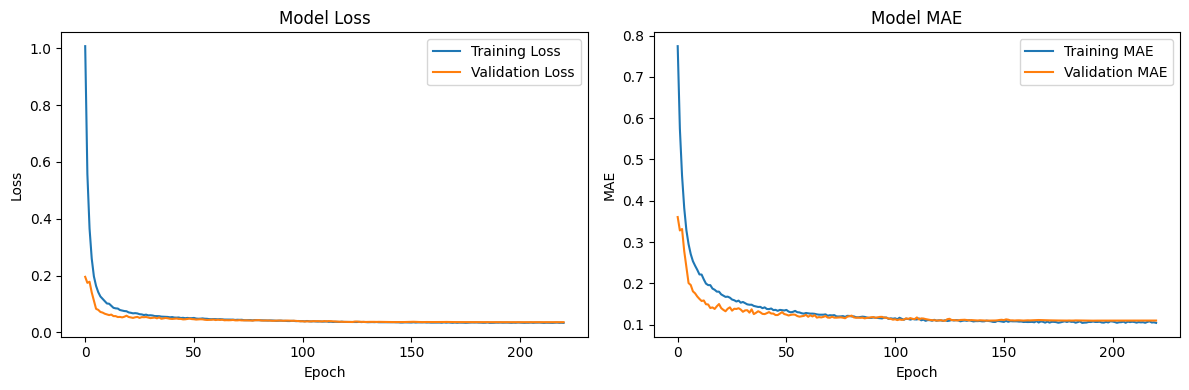

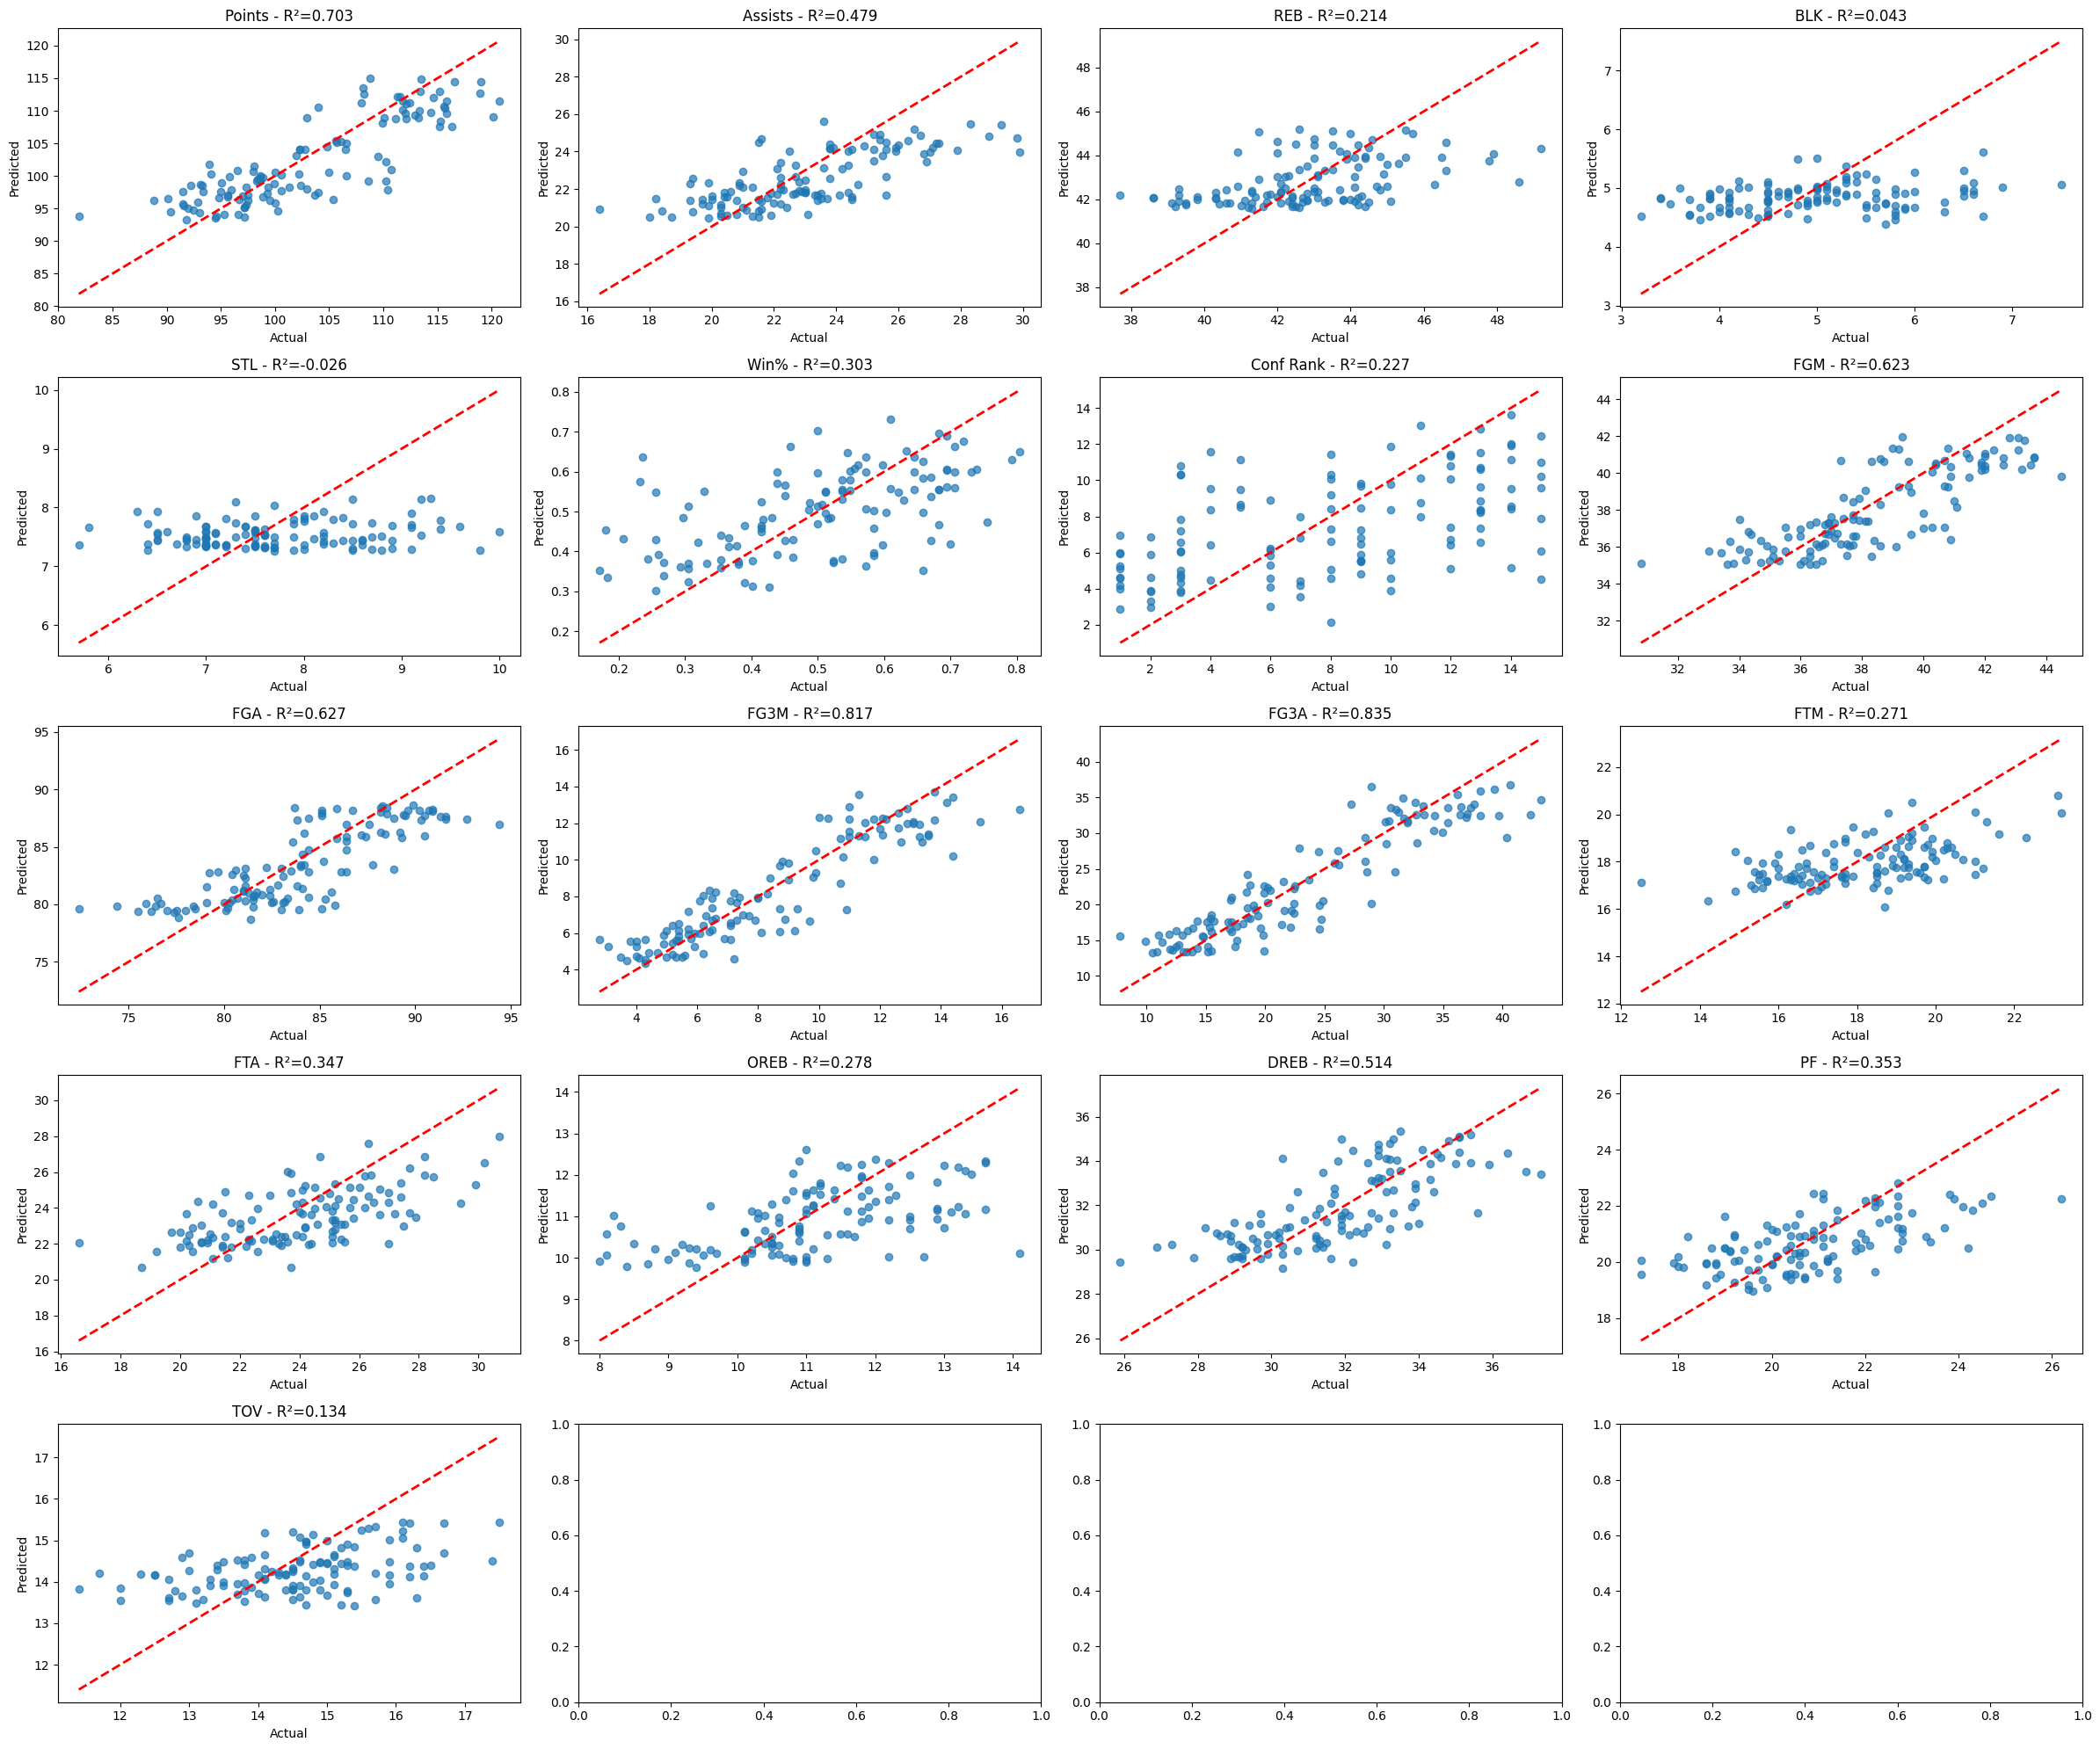

In [15]:
def mean_pool(t):
    return tf.reduce_mean(t, axis=1)

def max_pool(t):
    return tf.reduce_max(t, axis=1)



def create_enhanced_attention_nba_model(input_shape, output_dim):
    inputs = Input(shape=input_shape[1:])

    # Add Gaussian noise for regularization
    x = GaussianNoise(0.05)(inputs)

    # === Transformer Block 1 ===
    attn1 = MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.1)(x, x)
    x = Add()([x, attn1])
    x = LayerNormalization()(x)

    # === Transformer Block 2 ===
    attn2 = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(x, x)
    x = Add()([x, attn2])
    x = LayerNormalization()(x)

    # === Transformer Block 3 ===
    attn3 = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(x, x)
    x = Add()([x, attn3])
    x = LayerNormalization()(x)

    # === Aggregation: Mean + Max Pooling ===
    # mean_pool = Lambda(lambda t: tf.reduce_mean(t, axis=1), output_shape=lambda s: (s[0], s[2]))(x)
    # max_pool = Lambda(lambda t: tf.reduce_max(t, axis=1), output_shape=lambda s: (s[0], s[2]))(x)
    # team_representation = Concatenate()([mean_pool, max_pool])
    mean_pool_layer = Lambda(mean_pool, name="mean_pool")(x)
    max_pool_layer = Lambda(max_pool, name="max_pool")(x)
    team_representation = Concatenate()([mean_pool_layer, max_pool_layer])

    # === MLP Head with Residual Blocks ===
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-5))(team_representation)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Residual block 1
    x_res1 = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x_res1 = BatchNormalization()(x_res1)
    x_res1 = Dropout(0.2)(x_res1)
    x = Add()([x, x_res1])

    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Residual block 2
    x_res2 = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x_res2 = BatchNormalization()(x_res2)
    x_res2 = Dropout(0.2)(x_res2)
    x = Add()([x, x_res2])

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = Dropout(0.1)(x)

    outputs = Dense(output_dim, activation='linear', name='team_performance')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError()]
    )

    return model


# Create attention-based model
print("🧠 Creating attention-based NBA model...")
enhanced_attention_model = create_enhanced_attention_nba_model(X_train_final.shape, Y_train_final.shape[1])
enhanced_attention_model.summary()

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=12,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'enhanced_attention_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the attention model
print("\n🏀 Training attention-based NBA model...")
history = enhanced_attention_model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=400,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



# Make predictions on test set
print("\n🔮 Making predictions on test set...")
Y_pred_scaled = enhanced_attention_model.predict(X_test_scaled)
print("Predicted all Y shape")
print(Y_pred_scaled.shape)

# Inverse transform to get original scale
Y_test_original = y_scaler.inverse_transform(Y_test_scaled)
Y_pred_original = y_scaler.inverse_transform(Y_pred_scaled)

# Calculate metrics
mae = mean_absolute_error(Y_test_original, Y_pred_original)
mse = mean_squared_error(Y_test_original, Y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_original, Y_pred_original)

print("\n" + "="*60)
print("🎯 TEST SET RESULTS - HOW FAR FROM TRUTH")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variance")

# Team performance labels (what the model predicts)
performance_labels = [
    "Points", "Assists", "Rebounds", "Blocks", "Steals",
    "Win %", "Conf Rank", "FGM", "FGA", "3PM", "3PA",
    "FTM", "FTA", "OREB", "DREB", "Fouls", "Turnovers"
]

print("\n📊 DETAILED RESULTS BY METRIC:")
print("-" * 60)
for i, label in enumerate(performance_labels):
    actual_values = Y_test_original[:, i]
    predicted_values = Y_pred_original[:, i]

    metric_mae = mean_absolute_error(actual_values, predicted_values)
    metric_r2 = r2_score(actual_values, predicted_values)

    print(f"{label:12s}: MAE={metric_mae:6.2f}, R²={metric_r2:6.3f}")

print("\n🏆 SAMPLE TEAM PREDICTIONS:")
print("-" * 80)
# Get sample team names from test data
sample_teams = list(data.keys())[:25]  # First 5 teams

for i, team_key in enumerate(sample_teams):
    team_name = team_key.split('_')[0]
    print(f"\n{team_name} (2023 season):")
    print("Metric          Actual    Predicted    Error")
    print("-" * 45)

    for j, label in enumerate(performance_labels):  # Show first 8 metrics
        actual = Y_test_original[i, j]
        predicted = Y_pred_original[i, j]
        error = abs(actual - predicted)
        print(f"{label:12s}: {actual:8.1f} {predicted:10.1f} {error:8.1f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot for key metrics
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
key_metrics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Points, Assists, REB, BLK, STL, Win%, Conf Rank, FGM, FGA, FG3M, FG3A, FTM, FTA, OREB, DREB, PF, TOV
metric_names = ["Points", "Assists", "REB", "BLK", "STL", "Win%", "Conf Rank", "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "OREB", "DREB", "PF", "TOV"]

for idx, (metric_idx, ax) in enumerate(zip(key_metrics, axes.flat)):
    actual = Y_test_original[:, metric_idx]
    predicted = Y_pred_original[:, metric_idx]

    ax.scatter(actual, predicted, alpha=0.7)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{metric_names[idx]} - R²={r2_score(actual, predicted):.3f}')

plt.tight_layout()
plt.show()


## Deeper Multi-Head Attention Model


**Model -**

Input: 8 players × stats.

4 Multi-Head Attention blocks (varied heads, dims, cross-layer attention).

Team rep: global average pooling.

MLP head: large, deep, with 3 residual blocks.

Dual outputs: Main output, Specialized output (for harder stats), Combined via learned softmax weighting.

Loss: Huber

Optimizer: Adam (↑LR, weight decay, clipnorm)


**Training -**

400 epochs, early stopping, LR reduction, checkpointing.

**Evaluation -**

Predicts test set.

Reports MAE, RMSE, R² (overall + per-metric).

Prints sample team predictions.

**Visualization -**

Loss & MAE curves.

Actual vs. predicted scatter plots (per metric).

🧠 Creating attention-based NBA model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 8, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │    251,934 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 8, 30)     │          0 │ input_layer_3[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │    141,726 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     63,006 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 30)     │     98,430 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 8, 30)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 30)     │         60 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 30)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1024)      │     31,744 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_23[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,153,068 (15.84 MB)

 Trainable params: 4,140,268 (15.79 MB)

 Non-trainable params: 12,800 (50.00 KB)


🏀 Training attention-based NBA model...
Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2574 - mae: 0.5838 
Epoch 1: val_loss improved from inf to 0.09665, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.2540 - mae: 0.5789 - val_loss: 0.0966 - val_mae: 0.3959 - learning_rate: 0.0010
Epoch 2/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1028 - mae: 0.3561
Epoch 2: val_loss improved from 0.09665 to 0.09254, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1003 - mae: 0.3519 - val_loss: 0.0925 - val_mae: 0.3844 - learning_rate: 0.0010
Epoch 3/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0641 - mae: 0.2829
Epoch 3: val_loss improved from 0.09254 to 0.07996, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0626 - mae: 0.2795 - val_loss: 0.0800 - val_mae: 0.3507 - learning_rate: 0.0010
Epoch 4/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0445 - mae: 0.2339
Epoch 4: val_loss improved from 0.07996 to 0.06265, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0443 - mae: 0.2334 - val_loss: 0.0626 - val_mae: 0.3022 - learning_rate: 0.0010
Epoch 5/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0372 - mae: 0.2153
Epoch 5: val_loss improved from 0.06265 to 0.04804, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0368 - mae: 0.2143 - val_loss: 0.0480 - val_mae: 0.2540 - learning_rate: 0.0010
Epoch 6/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0333 - mae: 0.2047
Epoch 6: val_loss improved from 0.04804 to 0.04716, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0331 - mae: 0.2039 - val_loss: 0.0472 - val_mae: 0.2498 - learning_rate: 0.0010
Epoch 7/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 - mae: 0.1867
Epoch 7: val_loss improved from 0.04716 to 0.04067, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0284 - mae: 0.1866 - val_loss: 0.0407 - val_mae: 0.2269 - learning_rate: 0.0010
Epoch 8/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0268 - mae: 0.1827
Epoch 8: val_loss did not improve from 0.04067
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - mae: 0.1819 - val_loss: 0.0418 - val_mae: 0.2335 - learning_rate: 0.0010
Epoch 9/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245 - mae: 0.1723
Epoch 9: val_loss improved from 0.04067 to 0.03717, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0244 - mae: 0.1722 - val_loss: 0.0372 - val_mae: 0.2180 - learning_rate: 0.0010
Epoch 10/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 - mae: 0.1648
Epoch 10: val_loss did not improve from 0.03717
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mae: 0.1646 - val_loss: 0.0403 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 11/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0216 - mae: 0.1631
Epoch 11: val_loss improved from 0.03717 to 0.02815, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0215 - mae: 0.1627 - val_loss: 0.0282 - val_mae: 0.1868 - learning_rate: 0.0010
Epoch 12/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 - mae: 0.1565
Epoch 12: val_loss improved from 0.02815 to 0.02607, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0200 - mae: 0.1565 - val_loss: 0.0261 - val_mae: 0.1792 - learning_rate: 0.0010
Epoch 13/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - mae: 0.1546
Epoch 13: val_loss improved from 0.02607 to 0.02316, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0191 - mae: 0.1539 - val_loss: 0.0232 - val_mae: 0.1672 - learning_rate: 0.0010
Epoch 14/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0195 - mae: 0.1544
Epoch 14: val_loss improved from 0.02316 to 0.02165, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0195 - mae: 0.1542 - val_loss: 0.0216 - val_mae: 0.1604 - learning_rate: 0.0010
Epoch 15/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - mae: 0.1485
Epoch 15: val_loss did not improve from 0.02165
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0180 - mae: 0.1488 - val_loss: 0.0229 - val_mae: 0.1645 - learning_rate: 0.0010
Epoch 16/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - mae: 0.1424
Epoch 16: val_loss did not improve from 0.02165
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0170 - mae: 0.1428 - val_loss: 0.0223 - val_mae: 0.1614 - learning_rate: 0.0010
Epoch 17/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - mae: 0.1434
Epoch 17: val_loss did not improve from 0.02165
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0170 - mae: 0.1434 - val_loss: 0.0241 - val_mae: 0.1701 - learning_rate: 0.0010
Epoch 18/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - mae: 0.1404
Epoch 18: va

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0166 - mae: 0.1411 - val_loss: 0.0195 - val_mae: 0.1519 - learning_rate: 0.0010
Epoch 20/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.1369
Epoch 20: val_loss improved from 0.01948 to 0.01839, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0155 - mae: 0.1372 - val_loss: 0.0184 - val_mae: 0.1479 - learning_rate: 0.0010
Epoch 21/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - mae: 0.1337
Epoch 21: val_loss improved from 0.01839 to 0.01616, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0147 - mae: 0.1341 - val_loss: 0.0162 - val_mae: 0.1400 - learning_rate: 0.0010
Epoch 22/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - mae: 0.1389
Epoch 22: val_loss improved from 0.01616 to 0.01612, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0157 - mae: 0.1382 - val_loss: 0.0161 - val_mae: 0.1394 - learning_rate: 0.0010
Epoch 23/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.1367
Epoch 23: val_loss did not improve from 0.01612
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.1364 - val_loss: 0.0162 - val_mae: 0.1400 - learning_rate: 0.0010
Epoch 24/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - mae: 0.1321
Epoch 24: val_loss did not improve from 0.01612
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - mae: 0.1324 - val_loss: 0.0161 - val_mae: 0.1398 - learning_rate: 0.0010
Epoch 25/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - mae: 0.1329
Epoch 25: val_loss did not improve from 0.01612
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - mae: 0.1332 - val_loss: 0.0162 - val_mae: 0.1392 - learning_rate: 0.0010
Epoch 26/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - mae: 0.1327
Epoch 26: va

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0147 - mae: 0.1326 - val_loss: 0.0150 - val_mae: 0.1330 - learning_rate: 0.0010
Epoch 27/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - mae: 0.1274
Epoch 27: val_loss improved from 0.01500 to 0.01471, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0135 - mae: 0.1277 - val_loss: 0.0147 - val_mae: 0.1315 - learning_rate: 0.0010
Epoch 28/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mae: 0.1310
Epoch 28: val_loss improved from 0.01471 to 0.01432, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0143 - mae: 0.1309 - val_loss: 0.0143 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 29/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137 - mae: 0.1287
Epoch 29: val_loss improved from 0.01432 to 0.01338, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - mae: 0.1292 - val_loss: 0.0134 - val_mae: 0.1263 - learning_rate: 0.0010
Epoch 30/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142 - mae: 0.1308
Epoch 30: val_loss did not improve from 0.01338
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0142 - mae: 0.1307 - val_loss: 0.0148 - val_mae: 0.1326 - learning_rate: 0.0010
Epoch 31/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - mae: 0.1274
Epoch 31: val_loss did not improve from 0.01338
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - mae: 0.1276 - val_loss: 0.0140 - val_mae: 0.1293 - learning_rate: 0.0010
Epoch 32/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - mae: 0.1253
Epoch 32: val_loss did not improve from 0.01338
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - mae: 0.1257 - val_loss: 0.0136 - val_mae: 0.1273 - learning_rate: 0.0010
Epoch 33/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.1261
Epoch 33: va

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0136 - mae: 0.1283 - val_loss: 0.0132 - val_mae: 0.1245 - learning_rate: 0.0010
Epoch 35/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - mae: 0.1256
Epoch 35: val_loss improved from 0.01320 to 0.01313, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0131 - mae: 0.1257 - val_loss: 0.0131 - val_mae: 0.1238 - learning_rate: 0.0010
Epoch 36/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.1243
Epoch 36: val_loss improved from 0.01313 to 0.01259, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0130 - mae: 0.1244 - val_loss: 0.0126 - val_mae: 0.1219 - learning_rate: 0.0010
Epoch 37/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - mae: 0.1224
Epoch 37: val_loss did not improve from 0.01259
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - mae: 0.1228 - val_loss: 0.0131 - val_mae: 0.1241 - learning_rate: 0.0010
Epoch 38/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.1242
Epoch 38: val_loss did not improve from 0.01259
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - mae: 0.1242 - val_loss: 0.0133 - val_mae: 0.1246 - learning_rate: 0.0010
Epoch 39/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.1210
Epoch 39: val_loss improved from 0.01259 to 0.01257, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125 - mae: 0.1214 - val_loss: 0.0126 - val_mae: 0.1212 - learning_rate: 0.0010
Epoch 40/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.1225
Epoch 40: val_loss improved from 0.01257 to 0.01237, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0126 - mae: 0.1229 - val_loss: 0.0124 - val_mae: 0.1203 - learning_rate: 0.0010
Epoch 41/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - mae: 0.1206
Epoch 41: val_loss improved from 0.01237 to 0.01231, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0125 - mae: 0.1213 - val_loss: 0.0123 - val_mae: 0.1198 - learning_rate: 0.0010
Epoch 42/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mae: 0.1220
Epoch 42: val_loss improved from 0.01231 to 0.01199, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0127 - mae: 0.1225 - val_loss: 0.0120 - val_mae: 0.1179 - learning_rate: 0.0010
Epoch 43/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - mae: 0.1221
Epoch 43: val_loss improved from 0.01199 to 0.01197, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0125 - mae: 0.1226 - val_loss: 0.0120 - val_mae: 0.1178 - learning_rate: 0.0010
Epoch 44/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 - mae: 0.1249
Epoch 44: val_loss did not improve from 0.01197
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - mae: 0.1250 - val_loss: 0.0121 - val_mae: 0.1181 - learning_rate: 0.0010
Epoch 45/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - mae: 0.1219
Epoch 45: val_loss improved from 0.01197 to 0.01192, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0125 - mae: 0.1220 - val_loss: 0.0119 - val_mae: 0.1174 - learning_rate: 0.0010
Epoch 46/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.1229
Epoch 46: val_loss improved from 0.01192 to 0.01169, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0129 - mae: 0.1228 - val_loss: 0.0117 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 47/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - mae: 0.1244
Epoch 47: val_loss did not improve from 0.01169
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - mae: 0.1237 - val_loss: 0.0119 - val_mae: 0.1172 - learning_rate: 0.0010
Epoch 48/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - mae: 0.1243
Epoch 48: val_loss improved from 0.01169 to 0.01165, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0128 - mae: 0.1231 - val_loss: 0.0117 - val_mae: 0.1164 - learning_rate: 0.0010
Epoch 49/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 - mae: 0.1207
Epoch 49: val_loss improved from 0.01165 to 0.01147, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0122 - mae: 0.1206 - val_loss: 0.0115 - val_mae: 0.1169 - learning_rate: 0.0010
Epoch 50/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mae: 0.1207
Epoch 50: val_loss did not improve from 0.01147
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124 - mae: 0.1206 - val_loss: 0.0118 - val_mae: 0.1177 - learning_rate: 0.0010
Epoch 51/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - mae: 0.1201
Epoch 51: val_loss did not improve from 0.01147
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121 - mae: 0.1201 - val_loss: 0.0115 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 52/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - mae: 0.1192
Epoch 52: val_loss improved from 0.01147 to 0.01145, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0120 - mae: 0.1192 - val_loss: 0.0115 - val_mae: 0.1159 - learning_rate: 0.0010
Epoch 53/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.1186
Epoch 53: val_loss improved from 0.01145 to 0.01140, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0117 - mae: 0.1187 - val_loss: 0.0114 - val_mae: 0.1148 - learning_rate: 0.0010
Epoch 54/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - mae: 0.1178
Epoch 54: val_loss did not improve from 0.01140
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119 - mae: 0.1177 - val_loss: 0.0115 - val_mae: 0.1158 - learning_rate: 0.0010
Epoch 55/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - mae: 0.1193
Epoch 55: val_loss did not improve from 0.01140
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119 - mae: 0.1194 - val_loss: 0.0114 - val_mae: 0.1154 - learning_rate: 0.0010
Epoch 56/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118 - mae: 0.1187
Epoch 56: val_loss did not improve from 0.01140
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - mae: 0.1188 - val_loss: 0.0117 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 57/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - mae: 0.1195
Epoch 57: va

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0120 - mae: 0.1195 - val_loss: 0.0113 - val_mae: 0.1150 - learning_rate: 0.0010
Epoch 58/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.1150
Epoch 58: val_loss did not improve from 0.01133
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - mae: 0.1156 - val_loss: 0.0115 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 59/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - mae: 0.1168
Epoch 59: val_loss improved from 0.01133 to 0.01129, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0114 - mae: 0.1170 - val_loss: 0.0113 - val_mae: 0.1146 - learning_rate: 0.0010
Epoch 60/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - mae: 0.1196
Epoch 60: val_loss improved from 0.01129 to 0.01118, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0118 - mae: 0.1193 - val_loss: 0.0112 - val_mae: 0.1142 - learning_rate: 0.0010
Epoch 61/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.1155
Epoch 61: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113 - mae: 0.1161 - val_loss: 0.0113 - val_mae: 0.1149 - learning_rate: 0.0010
Epoch 62/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - mae: 0.1176
Epoch 62: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0116 - mae: 0.1180 - val_loss: 0.0115 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 63/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mae: 0.1165
Epoch 63: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - mae: 0.1167 - val_loss: 0.0116 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 64/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mae: 0.1142
Epoch 64: va

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0106 - mae: 0.1128 - val_loss: 0.0112 - val_mae: 0.1146 - learning_rate: 5.0000e-04
Epoch 77/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mae: 0.1114
Epoch 77: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mae: 0.1118 - val_loss: 0.0112 - val_mae: 0.1150 - learning_rate: 5.0000e-04
Epoch 78/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.1121
Epoch 78: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - mae: 0.1123 - val_loss: 0.0112 - val_mae: 0.1149 - learning_rate: 5.0000e-04
Epoch 79/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mae: 0.1118
Epoch 79: val_loss did not improve from 0.01118
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - mae: 0.1122 - val_loss: 0.0113 - val_mae: 0.1153 - learning_rate: 5.0000e-04
Epoch 80/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0103 - mae: 0.1112 - val_loss: 0.0112 - val_mae: 0.1146 - learning_rate: 5.0000e-04
Epoch 81/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.1098
Epoch 81: val_loss did not improve from 0.01115
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - mae: 0.1111 - val_loss: 0.0114 - val_mae: 0.1155 - learning_rate: 5.0000e-04
Epoch 82/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.1116
Epoch 82: val_loss did not improve from 0.01115
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0103 - mae: 0.1119 - val_loss: 0.0113 - val_mae: 0.1153 - learning_rate: 5.0000e-04
Epoch 83/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.1139
Epoch 83: val_loss did not improve from 0.01115
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - mae: 0.1139 - val_loss: 0.0115 - val_mae: 0.1158 - learning_rate: 5.0000e-04
Epoch 84/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0103 - mae: 0.1110 - val_loss: 0.0111 - val_mae: 0.1138 - learning_rate: 2.5000e-04
Epoch 89/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mae: 0.1115
Epoch 89: val_loss improved from 0.01107 to 0.01103, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0104 - mae: 0.1116 - val_loss: 0.0110 - val_mae: 0.1137 - learning_rate: 2.5000e-04
Epoch 90/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.1122
Epoch 90: val_loss did not improve from 0.01103
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - mae: 0.1119 - val_loss: 0.0110 - val_mae: 0.1137 - learning_rate: 2.5000e-04
Epoch 91/400
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.1126
Epoch 91: val_loss improved from 0.01103 to 0.01079, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0106 - mae: 0.1125 - val_loss: 0.0108 - val_mae: 0.1130 - learning_rate: 2.5000e-04
Epoch 92/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - mae: 0.1122
Epoch 92: val_loss improved from 0.01079 to 0.01074, saving model to deeper_attention_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0105 - mae: 0.1121 - val_loss: 0.0107 - val_mae: 0.1129 - learning_rate: 2.5000e-04
Epoch 93/400
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mae: 0.1112
Epoch 93: val_loss did not improve from 0.01074
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - mae: 0.1116 - val_loss: 0.0108 - val_mae: 0.1133 - learning_rate: 2.5000e-04
Epoch 94/400
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - mae: 0.1127
Epoch 94: val_loss did not improve from 0.01074
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - mae: 0.1127 - val_loss: 0.0109 - val_mae: 0.1136 - learning_rate: 2.5000e-04
Epoch 95/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.1111
Epoch 95: val_loss did not improve from 0.01074
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - mae: 0.1112 - val_loss: 0.0109 - val_mae: 0.1138 - learning_rate: 2.5000e-04
Epoch 96/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.1

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0103 - mae: 0.1116 - val_loss: 0.0107 - val_mae: 0.1127 - learning_rate: 1.2500e-04
Epoch 113/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.1118
Epoch 113: val_loss did not improve from 0.01071
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mae: 0.1119 - val_loss: 0.0107 - val_mae: 0.1126 - learning_rate: 1.2500e-04
Epoch 114/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.1100
Epoch 114: val_loss did not improve from 0.01071
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - mae: 0.1100 - val_loss: 0.0107 - val_mae: 0.1126 - learning_rate: 1.2500e-04
Epoch 115/400
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mae: 0.1108
Epoch 115: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 115: val_loss did not improve from 0.01071
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - mae: 0.1106 - val_loss: 0.0108 - val_mae: 0.1127 - learning_rate: 1.25

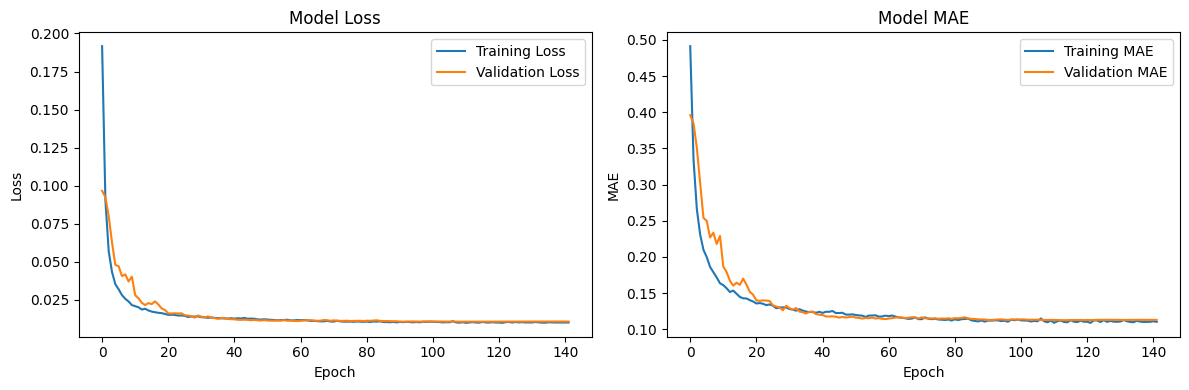

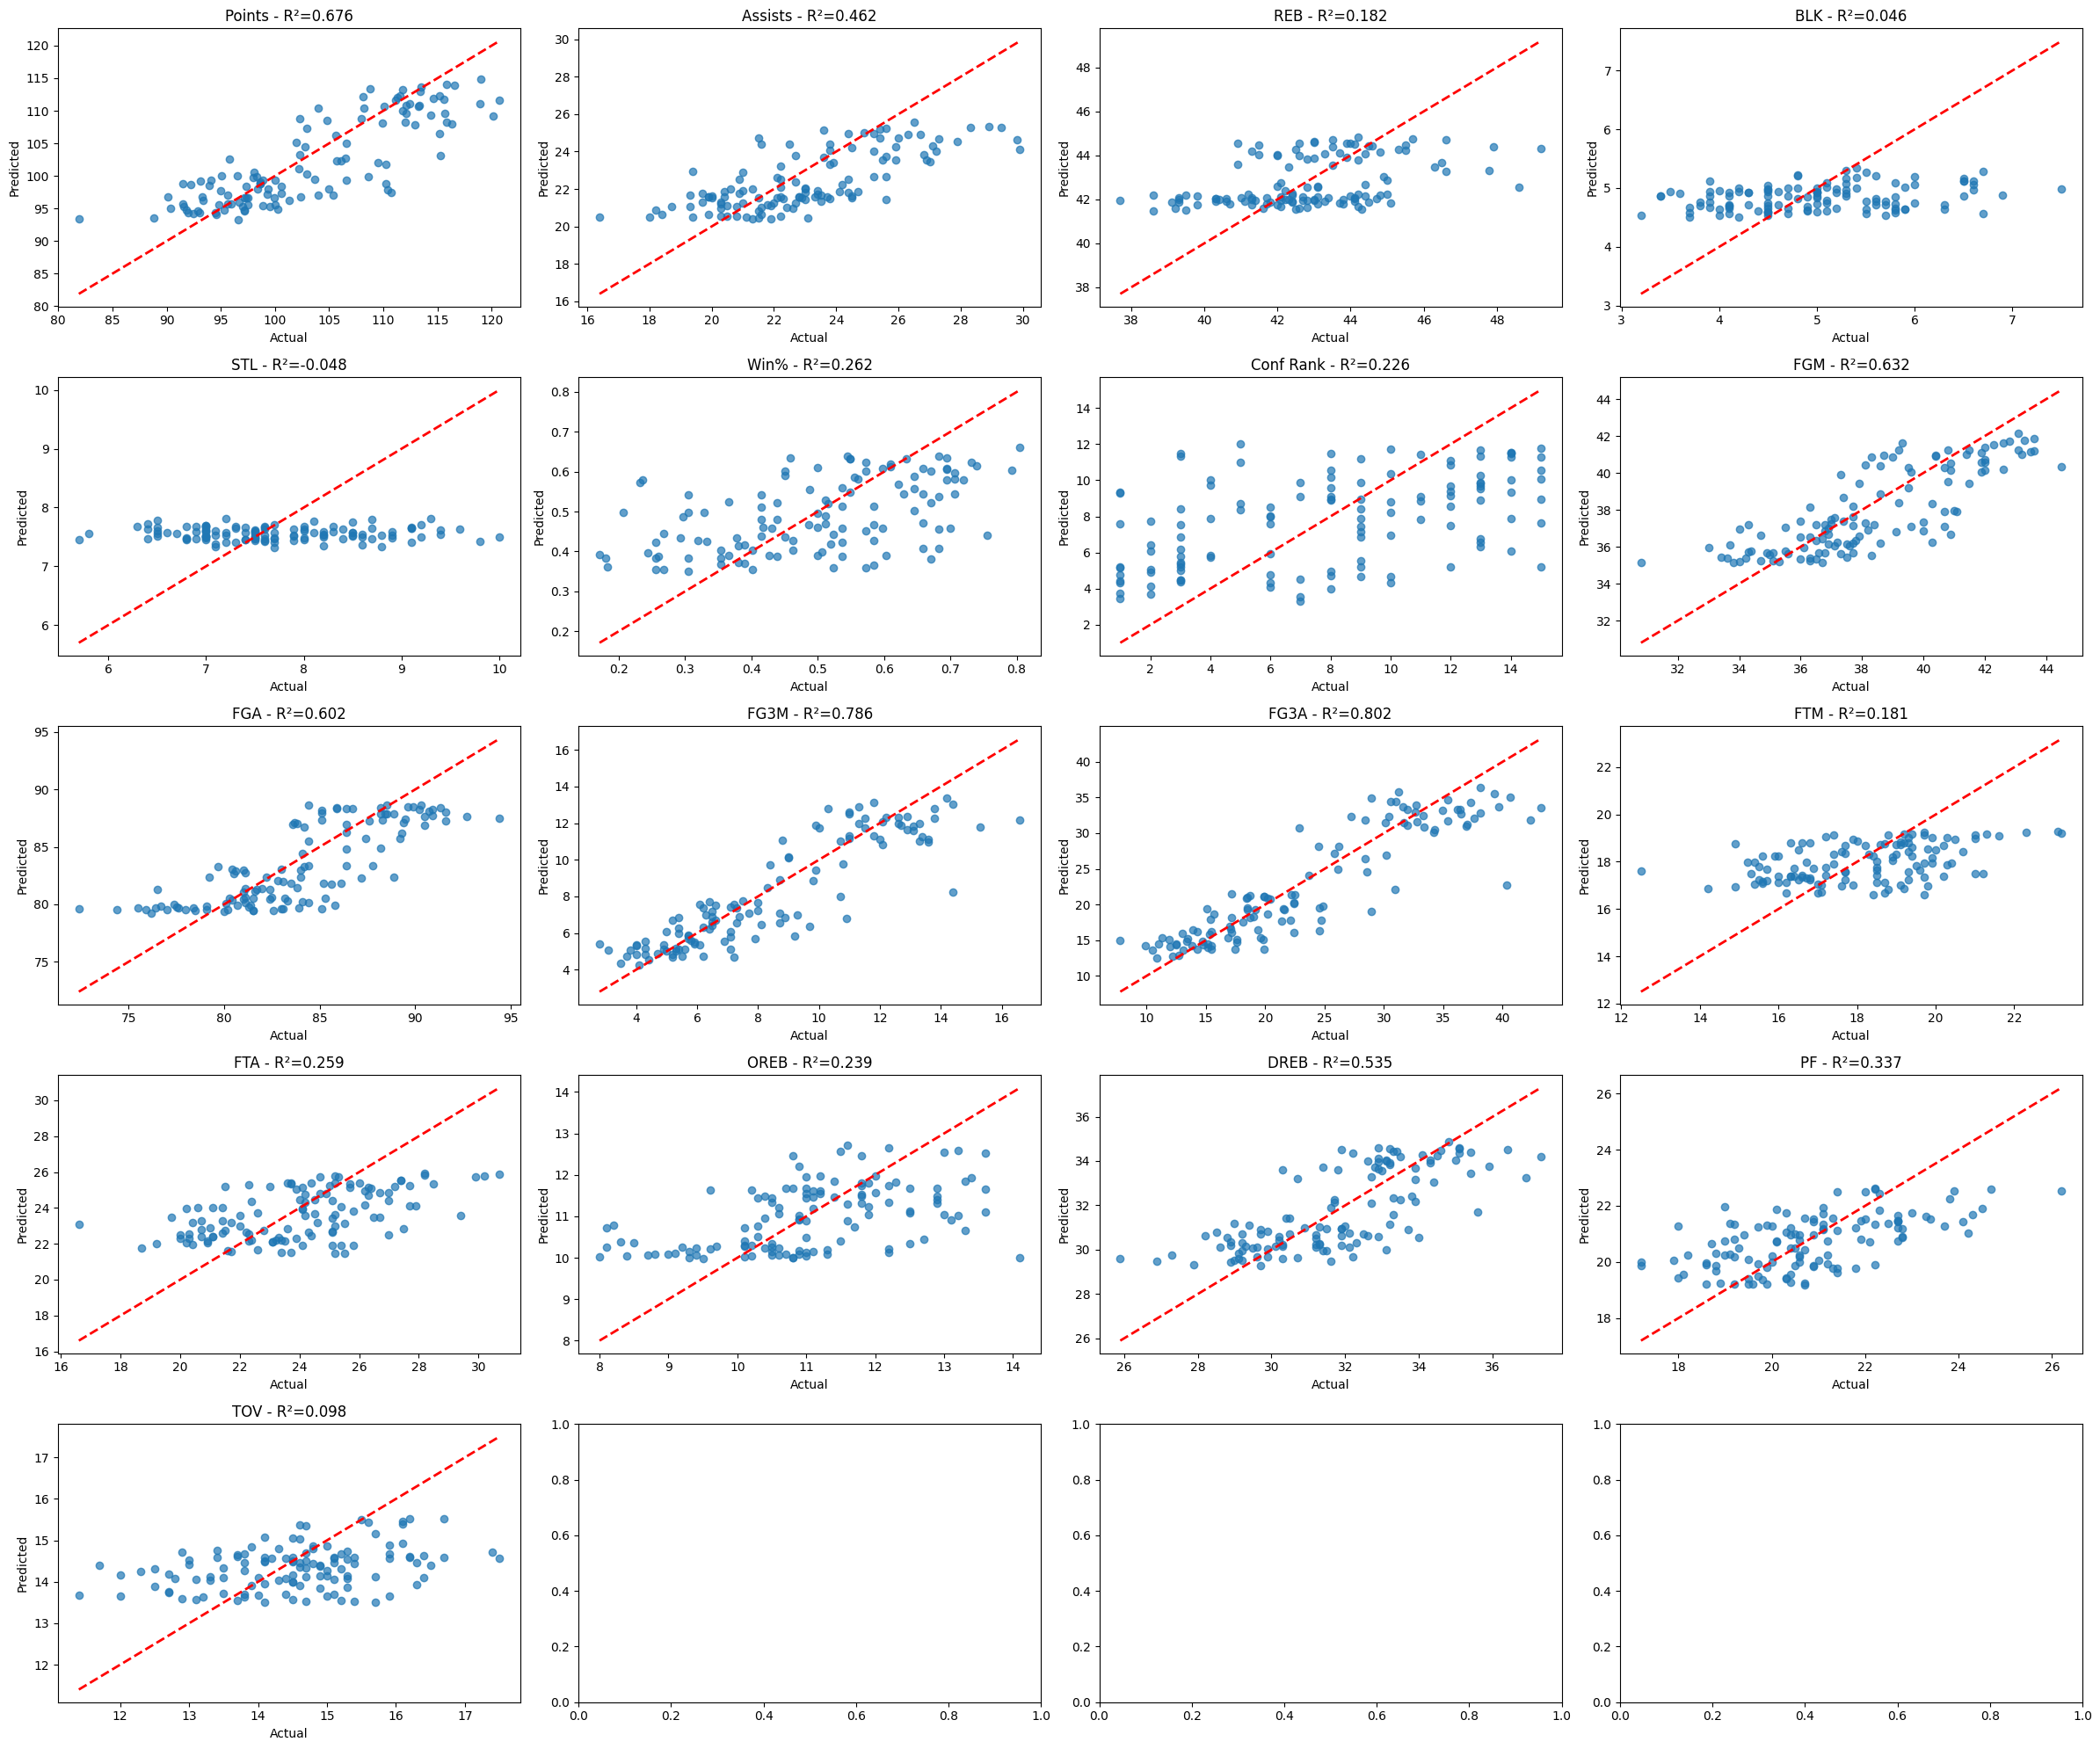

In [ ]:
def create_deeper_attention_nba_model(input_shape, output_dim):
    """
    Enhanced multi-head attention model with significantly more parameters
    for understanding complex player interactions and team dynamics
    """
    # Input: (batch_size, 8 players, num_stats)
    inputs = Input(shape=input_shape[1:])

    # Multi-Head Attention Block 1 - Large capacity
    attn_output1 = MultiHeadAttention(
        num_heads=16,
        key_dim=128,
        value_dim=128,
        dropout=0.15
    )(inputs, inputs)

    attn_output1 = Add()([inputs, attn_output1])
    attn_output1 = LayerNormalization()(attn_output1)

    # Multi-Head Attention Block 2 - Medium capacity
    attn_output2 = MultiHeadAttention(
        num_heads=12,
        key_dim=96,
        value_dim=96,
        dropout=0.12
    )(attn_output1, attn_output1)

    attn_output2 = Add()([attn_output1, attn_output2])
    attn_output2 = LayerNormalization()(attn_output2)

    # Multi-Head Attention Block 3 - Fine-grained
    attn_output3 = MultiHeadAttention(
        num_heads=8,
        key_dim=64,
        value_dim=64,
        dropout=0.1
    )(attn_output2, attn_output2)

    attn_output3 = Add()([attn_output2, attn_output3])
    attn_output3 = LayerNormalization()(attn_output3)

    # Multi-Head Attention Block 4 - Cross attention
    attn_output4 = MultiHeadAttention(
        num_heads=10,
        key_dim=80,
        value_dim=80,
        dropout=0.12
    )(attn_output3, attn_output1)  # Cross attention between layers

    attn_output4 = Add()([attn_output3, attn_output4])
    attn_output4 = LayerNormalization()(attn_output4)

    # Global Average Pooling using Lambda
    team_representation = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attn_output4)

    # Large MLP Head with more parameters
    x = Dense(1024, activation='relu')(team_representation)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(768, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.35)(x)

    # First residual block
    x_residual1 = Dense(768, activation='relu')(x)
    x_residual1 = BatchNormalization()(x_residual1)
    x_residual1 = Dropout(0.3)(x_residual1)
    x_residual1 = Dense(768, activation='relu')(x_residual1)
    x_residual1 = BatchNormalization()(x_residual1)
    x = Add()([x, x_residual1])

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second residual block
    x_residual2 = Dense(512, activation='relu')(x)
    x_residual2 = BatchNormalization()(x_residual2)
    x_residual2 = Dropout(0.25)(x_residual2)
    x_residual2 = Dense(512, activation='relu')(x_residual2)
    x_residual2 = BatchNormalization()(x_residual2)
    x = Add()([x, x_residual2])

    x = Dense(384, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    # Third residual block
    x_residual3 = Dense(384, activation='relu')(x)
    x_residual3 = BatchNormalization()(x_residual3)
    x_residual3 = Dropout(0.2)(x_residual3)
    x_residual3 = Dense(384, activation='relu')(x_residual3)
    x_residual3 = BatchNormalization()(x_residual3)
    x = Add()([x, x_residual3])

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(96, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Multi-head output with specialized branches
    # Main output
    main_output = Dense(output_dim, activation='linear', name='team_performance')(x)

    # Specialized branch for harder-to-predict stats (like STL)
    specialized_branch = Dense(128, activation='relu')(x)
    specialized_branch = Dropout(0.1)(specialized_branch)
    specialized_output = Dense(output_dim, activation='linear', name='specialized_output')(specialized_branch)

    # Combine outputs with learned weighting
    output_weights = Dense(2, activation='softmax', name='output_gate')(x)
    output_weights = Lambda(lambda w: tf.expand_dims(w, -1))(output_weights)

    # Stack and weight the outputs
    stacked_outputs = Lambda(lambda x: tf.stack(x, axis=1))([main_output, specialized_output])
    final_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([stacked_outputs, output_weights])

    model = Model(inputs=inputs, outputs=final_output)

    # More aggressive optimizer for breaking out of mean prediction
    optimizer = Adam(
        learning_rate=0.001,  # Slightly higher LR
        clipnorm=0.8,        # Tighter clipping
        weight_decay=1e-6     # Small weight decay
    )

    # Use Huber loss instead of MSE - less sensitive to outliers
    model.compile(
        optimizer=optimizer,
        loss='huber',
        metrics=['mae']
    )

    return model




# Create attention-based model
print("🧠 Creating attention-based NBA model...")
deeper_attention_model = create_deeper_attention_nba_model(X_train_final.shape, Y_train_final.shape[1])
deeper_attention_model.summary()

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=12,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'deeper_attention_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the attention model
print("\n🏀 Training attention-based NBA model...")
history = deeper_attention_model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=400,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


# Make predictions on test set
print("\n🔮 Making predictions on test set...")
Y_pred_scaled = deeper_attention_model.predict(X_test_scaled)
print("Predicted all Y shape")
print(Y_pred_scaled.shape)

# Inverse transform to get original scale
Y_test_original = y_scaler.inverse_transform(Y_test_scaled)
Y_pred_original = y_scaler.inverse_transform(Y_pred_scaled)

# Calculate metrics
mae = mean_absolute_error(Y_test_original, Y_pred_original)
mse = mean_squared_error(Y_test_original, Y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_original, Y_pred_original)

print("\n" + "="*60)
print("🎯 TEST SET RESULTS - HOW FAR FROM TRUTH")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variance")

# Team performance labels (what the model predicts)
performance_labels = [
    "Points", "Assists", "Rebounds", "Blocks", "Steals",
    "Win %", "Conf Rank", "FGM", "FGA", "3PM", "3PA",
    "FTM", "FTA", "OREB", "DREB", "Fouls", "Turnovers"
]

print("\n📊 DETAILED RESULTS BY METRIC:")
print("-" * 60)
for i, label in enumerate(performance_labels):
    actual_values = Y_test_original[:, i]
    predicted_values = Y_pred_original[:, i]

    metric_mae = mean_absolute_error(actual_values, predicted_values)
    metric_r2 = r2_score(actual_values, predicted_values)

    print(f"{label:12s}: MAE={metric_mae:6.2f}, R²={metric_r2:6.3f}")

print("\n🏆 SAMPLE TEAM PREDICTIONS:")
print("-" * 80)
# Get sample team names from test data
sample_teams = list(data.keys())[:25]  # First 5 teams

for i, team_key in enumerate(sample_teams):
    team_name = team_key.split('_')[0]
    print(f"\n{team_name} (2023 season):")
    print("Metric          Actual    Predicted    Error")
    print("-" * 45)

    for j, label in enumerate(performance_labels):  # Show first 8 metrics
        actual = Y_test_original[i, j]
        predicted = Y_pred_original[i, j]
        error = abs(actual - predicted)
        print(f"{label:12s}: {actual:8.1f} {predicted:10.1f} {error:8.1f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot for key metrics
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
key_metrics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Points, Assists, REB, BLK, STL, Win%, Conf Rank, FGM, FGA, FG3M, FG3A, FTM, FTA, OREB, DREB, PF, TOV
metric_names = ["Points", "Assists", "REB", "BLK", "STL", "Win%", "Conf Rank", "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "OREB", "DREB", "PF", "TOV"]

for idx, (metric_idx, ax) in enumerate(zip(key_metrics, axes.flat)):
    actual = Y_test_original[:, metric_idx]
    predicted = Y_pred_original[:, metric_idx]

    ax.scatter(actual, predicted, alpha=0.7)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{metric_names[idx]} - R²={r2_score(actual, predicted):.3f}')

plt.tight_layout()
plt.show()


# Save Best Model and Train scalers

Save the best model

In [16]:
from google.colab import files

# Make sure the model checkpoint file exists
model_path = 'enhanced_attention_model.h5'

# Download the model file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save the training scalers

In [17]:
import pickle

# Save scalers to disk
with open('x_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)

with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)


# Download
from google.colab import files

files.download('x_scaler.pkl')
files.download('y_scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>